✅ Demo file 'demo_area.geojson' created successfully.

🚀 Running DecomposeAndMerge with Strict Auto-Segmentation...
...Algorithm finished.
📊 Generating visualization...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 0 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(
/var/folders/w9/_qn43d_j5l37kv2ls_rf5z9m0000gn/T/ipykernel_6331/1565747999.py:245: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(segments))
/var/folders/w9/_qn43d_j5l37kv2ls_rf5z9m0000gn/T/ipykernel_6331/1565747999.py:270: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.set_aspect('equal', adjustable='box'); ax.legend(title="Auto-Detected Segments")
/var/folders/w9/_qn43d_

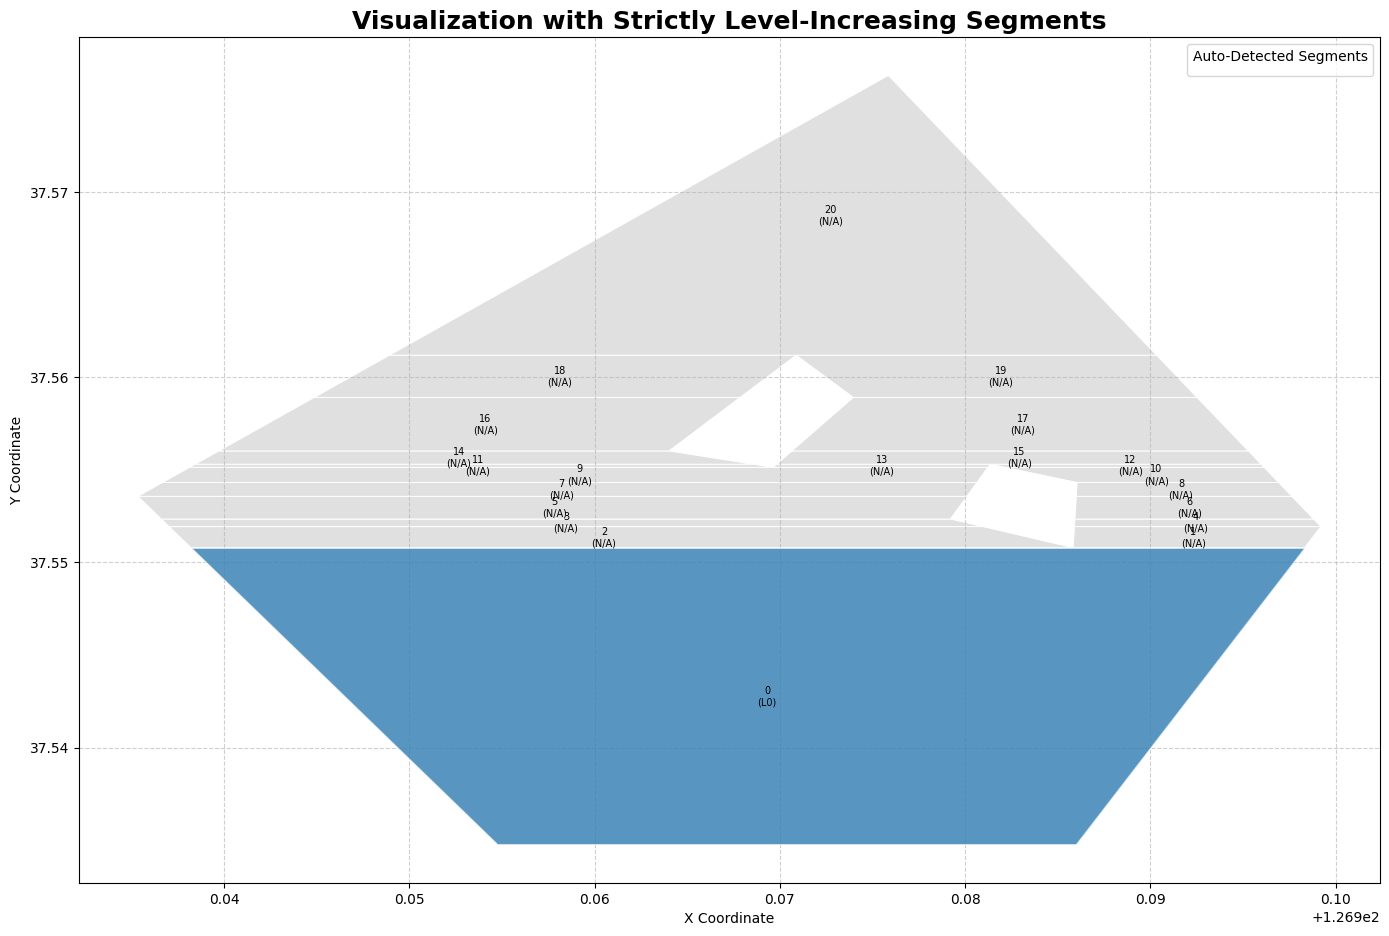

In [3]:
"""
DecomposeAndMerge (Strictly Level-Increasing Auto-Segmentation)

This final version enforces a strict segmentation rule:
A segment is cut whenever the path does not move to an adjacent node
at a strictly higher level. This perfectly aligns the segments with the
forward-moving, level-constrained path branches.

Requirements:
  - shapely, numpy, pandas, geopandas, matplotlib

Usage:
  python visualize_strict_segments.py
"""

import json
import math
import collections
from dataclasses import dataclass
from typing import List, Tuple, Dict, Set, Any

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, LineString, box, mapping
from shapely.ops import unary_union


# ------------------------- Geometry helpers (No Changes) -------------------------
def polygon_internal_angles(poly: Polygon):
    coords = list(poly.exterior.coords)[:-1]; n = len(coords)
    def angle(a, b, c):
        ax, ay = a; bx, by = b; cx, cy = c
        v1 = np.array([ax - bx, ay - by]); v2 = np.array([cx - bx, cy - by])
        n1 = np.linalg.norm(v1) + 1e-12; n2 = np.linalg.norm(v2) + 1e-12
        v1 = v1 / n1; v2 = v2 / n2
        dot = np.clip(np.dot(v1, v2), -1.0, 1.0); ang = math.degrees(math.acos(dot))
        cross = v1[0] * v2[1] - v1[1] * v2[0]
        if cross < 0: ang = 360 - ang
        return ang
    return [angle(coords[(i - 1) % n], coords[i], coords[(i + 1) % n]) for i in range(n)]

def Convex(poly: Polygon, angle_tol: float = 1e-6) -> bool:
    if poly.is_empty or (not poly.is_valid) or len(poly.interiors) > 0: return False
    for ang in polygon_internal_angles(poly):
        if ang > 180 + angle_tol: return False
    return True

def SharedEdgeLen(p: Polygon, q: Polygon) -> float:
    inter = p.boundary.intersection(q.boundary)
    if inter.is_empty: return 0.0
    if isinstance(inter, LineString): return inter.length
    length = 0.0
    for g in getattr(inter, "geoms", []):
        if isinstance(g, LineString): length += g.length
    return length

# ------------------------- Partition & Graph build (No Changes) -------------------------
def all_vertex_y_levels(geom) -> List[float]:
    ys = []; geoms = getattr(geom, 'geoms', [geom])
    for g in geoms:
        if isinstance(g, Polygon):
            ys.extend(np.array(g.exterior.coords)[:, 1])
            for ring in g.interiors: ys.extend(np.array(ring.coords)[:, 1])
    return sorted(list(set(ys)))

def PartitionHorizontal(A: Polygon, H: List[Polygon]) -> List[Polygon]:
    free = A.difference(unary_union(H)) if H else A
    if free.is_empty: return []
    ys = all_vertex_y_levels(free); minx, _, maxx, _ = free.bounds
    parts: List[Polygon] = []
    for i in range(len(ys) - 1):
        y0, y1 = ys[i], ys[i + 1]
        if y1 <= y0 + 1e-9: continue
        slab = box(minx - 1.0, y0, maxx + 1.0, y1); inter = free.intersection(slab)
        if not inter.is_empty:
            if isinstance(inter, Polygon): parts.append(inter)
            else:
                for g in getattr(inter, "geoms", []):
                    if isinstance(g, Polygon): parts.append(g)
    return parts

def BuildAdjacency(parts: List[Polygon], min_shared: float) -> Dict[int, Set[int]]:
    N = len(parts); adj: Dict[int, Set[int]] = {i: set() for i in range(N)}
    for i in range(N):
        for j in range(i + 1, N):
            if SharedEdgeLen(parts[i], parts[j]) > min_shared:
                adj[i].add(j); adj[j].add(i)
    return adj

# ------------------------- Level-Constrained DFS (No Changes) -------------------------
def DFS_Order_With_Levels(adj: Dict[int, Set[int]], root: int, N: int) -> Tuple[List[int], List[int]]:
    if N == 0: return [], []
    levels = [-1] * N
    if root < N:
        levels[root] = 0
        queue = collections.deque([root]); visited_for_level = {root}
        while queue:
            u = queue.popleft()
            for v in sorted(list(adj.get(u, set()))):
                if v not in visited_for_level:
                    visited_for_level.add(v); levels[v] = levels[u] + 1; queue.append(v)
    order: List[int] = []; visited_for_dfs = [False] * N
    if root < N:
        stack = [root]; visited_for_dfs[root] = True
        while stack:
            u = stack.pop(); order.append(u)
            for v in sorted(list(adj.get(u, set())), reverse=True):
                if not visited_for_dfs[v] and levels[v] > levels[u]:
                    visited_for_dfs[v] = True; stack.append(v)
    return order, levels

# ------------------------- Automatic Segmentation (MODIFIED with strict level check) -------------------------
@dataclass
class Segment:
    valid: bool; node_range: Tuple[int, int]; nodes: List[int]; edges: List[Tuple[int, int]]

# MODIFIED: Now takes 'levels' and uses a stricter condition for continuing a segment
def GenerateSegmentsFromPath(order: List[int], adj: Dict[int, Set[int]], levels: List[int]) -> List[Segment]:
    if not order:
        return []

    all_segments_nodes: List[List[int]] = []
    current_segment_nodes = [order[0]]

    for i in range(len(order) - 1):
        u, v = order[i], order[i+1]
        
        # THE KEY CHANGE: A segment continues ONLY IF the next node is adjacent AND its level is higher.
        is_continuous_branch = (v in adj.get(u, set())) and (levels[v] > levels[u])
        
        if is_continuous_branch:
            current_segment_nodes.append(v)
        else:
            # Cut the segment if the branch is broken or level does not increase
            all_segments_nodes.append(current_segment_nodes)
            current_segment_nodes = [v]
    
    all_segments_nodes.append(current_segment_nodes)

    final_segments: List[Segment] = []
    for nodes in all_segments_nodes:
        if not nodes: continue
        node_range = (nodes[0], nodes[-1])
        edges = []
        for i in range(len(nodes) - 1):
            u, v = nodes[i], nodes[i+1]
            if v in adj.get(u, set()):
                edges.append((u,v))
        final_segments.append(Segment(True, node_range, nodes, edges))
        
    return final_segments
    
# ------------------------- Merge (No Changes) -------------------------
def MergeSegment(parts: List[Polygon], seg_nodes: List[int], seg_edges: List[Tuple[int, int]], angle_tol: float) -> List[Polygon]:
    if not seg_nodes: return []
    poly_map: Dict[int, Polygon] = {nid: parts[nid] for nid in seg_nodes}
    adj: Dict[int, Set[int]] = {nid: set() for nid in seg_nodes}
    for (u, v) in seg_edges:
        if u in adj and v in adj: adj[u].add(v); adj[v].add(u)
    changed = True
    while changed and len(poly_map) > 1:
        changed = False
        current_nodes = [n for n in seg_nodes if n in poly_map]
        for i in range(len(current_nodes) - 1):
            u, v = current_nodes[i], current_nodes[i+1]
            if v not in adj.get(u, set()): continue
            pu, pv = poly_map[u], poly_map[v]
            if SharedEdgeLen(pu, pv) <= 1e-6: continue
            U = unary_union([pu, pv])
            if isinstance(U, Polygon) and Convex(U, angle_tol):
                poly_map[u] = U
                del poly_map[v]
                v_neighbors = list(adj.pop(v, set()))
                for w in v_neighbors:
                    if w in adj:
                        adj[w].discard(v)
                        if w != u: adj[w].add(u); adj[u].add(w)
                changed = True
                break
    return list(poly_map.values())

# ------------------------- Main algorithm (MODIFIED to pass levels to segment generator) -------------------------
def DecomposeAndMerge(A: Polygon, H: List[Polygon], min_shared: float, angle_tol: float, root: int = 0) -> Dict[str, Any]:
    parts = PartitionHorizontal(A, H)
    adj = BuildAdjacency(parts, min_shared)
    order, levels = DFS_Order_With_Levels(adj, root, len(parts))
    
    # --- CHANGE: Pass 'levels' to the segment generator for the strict check ---
    segments = GenerateSegmentsFromPath(order, adj, levels)
    # --------------------------------------------------------------------------
    
    merged_segments: List[List[Polygon]] = []
    for seg in segments:
        if seg.valid:
            Ms = MergeSegment(parts, seg.nodes[:], seg.edges[:], angle_tol)
        else:
            Ms = []
        merged_segments.append(Ms)
    return {
        "parts": parts, "adj": adj, "order": order, "levels": levels,
        "segments": segments, "merged_segments": merged_segments,
    }

# ------------------------- Demo File Creation (No Changes) -------------------------
def create_demo_geojson(filepath="demo_area.geojson"):
    A = Polygon([
            (126.975861, 37.576283),
            (126.935349, 37.553560),
            (126.954746, 37.534777),
            (126.985989, 37.534777),
            (126.999207, 37.551927)
        ])

    H = [
        Polygon([
            (126.970882, 37.561180),
            (126.964016, 37.556009),
            (126.969638, 37.555125),
            (126.973972, 37.558901)
        ]),
        Polygon([
            (126.981354, 37.555295),
            (126.979208, 37.552335),
            (126.985838, 37.550787),
            (126.986053, 37.554308)
        ])
    ]
    features = [{"type": "Feature", "properties": {"type": "area"}, "geometry": mapping(A)}]
    for i, h_poly in enumerate(H):
        features.append({"type": "Feature", "properties": {"type": "hole", "id": i}, "geometry": mapping(h_poly)})
    fc = {"type": "FeatureCollection", "features": features}
    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(fc, f, ensure_ascii=False, indent=2)
    print(f"✅ Demo file '{filepath}' created successfully.")

# ------------------------- Visualization (No Changes needed) -------------------------
def visualize_segments(result: Dict[str, Any]):
    parts = result["parts"]; segments = result["segments"]
    order = result["order"]; levels = result["levels"]
    fig, ax = plt.subplots(figsize=(14, 11))
    gpd.GeoSeries(parts).plot(ax=ax, color='#e0e0e0', edgecolor='white', linewidth=0.7, zorder=1)
    
    colors = plt.cm.get_cmap('tab10', len(segments))
    for i, seg in enumerate(segments):
        if not seg.valid: continue
        seg_polys = [parts[node_id] for node_id in seg.nodes if node_id < len(parts)]
        if not seg_polys: continue
        seg_union = unary_union(seg_polys)
        label = f"Segment {i+1}"
        gpd.GeoSeries([seg_union]).plot(ax=ax, color=colors(i), edgecolor='white', alpha=0.7, zorder=2, label=label)
    
    for i, p in enumerate(parts):
        point = p.representative_point()
        level = levels[i]
        label = f"{i}\n(L{level})" if level != -1 else f"{i}\n(N/A)"
        ax.text(point.x, point.y, label, fontsize=7, ha='center', va='center', color='black', zorder=4)

    points = {i: p.representative_point() for i, p in enumerate(parts)}
    for i in range(len(order) - 1):
        u, v = order[i], order[i+1]
        if u in points and v in points:
            p_start = points[u]; p_end = points[v]
            ax.annotate("", xy=(p_end.x, p_end.y), xytext=(p_start.x, p_start.y),
                        arrowprops=dict(arrowstyle="->", color="red", lw=1.2, shrinkA=5, shrinkB=5), zorder=3)
    
    ax.set_title("Visualization with Strictly Level-Increasing Segments", fontsize=18, fontweight='bold')
    ax.set_xlabel("X Coordinate"); ax.set_ylabel("Y Coordinate")
    ax.set_aspect('equal', adjustable='box'); ax.legend(title="Auto-Detected Segments")
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show() 

# ------------------------- Main script execution (No Changes needed) -------------------------
def main():
    geojson_path = "demo_area.geojson"; create_demo_geojson(geojson_path)
    gdf = gpd.read_file(geojson_path)
    A = gdf[gdf['type'] == 'area'].geometry.iloc[0]; H = list(gdf[gdf['type'] == 'hole'].geometry)
    
    print("\n🚀 Running DecomposeAndMerge with Strict Auto-Segmentation...")
    result = DecomposeAndMerge(A, H, min_shared=5.0, angle_tol=1e-6, root=0)
    print("...Algorithm finished.")
    print("📊 Generating visualization...")
    visualize_segments(result)

if __name__ == "__main__":
    main()

✅ Demo file 'demo_area.geojson' created successfully.

🚀 Running DecomposeAndMerge...
...Decomposition and merging finished.
🌿 Generating lawnmower paths...
...Generated 1 individual paths.
🔗 Connecting all paths with obstacle avoidance...
...Final path created.
📊 Generating visualization...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 0 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(
/var/folders/w9/_qn43d_j5l37kv2ls_rf5z9m0000gn/T/ipykernel_6331/3460373609.py:311: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(segments))
/var/folders/w9/_qn43d_j5l37kv2ls_rf5z9m0000gn/T/ipykernel_6331/3460373609.py:335: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.set_aspect('equal', adjustable='box'); ax.legend(title="Layers")


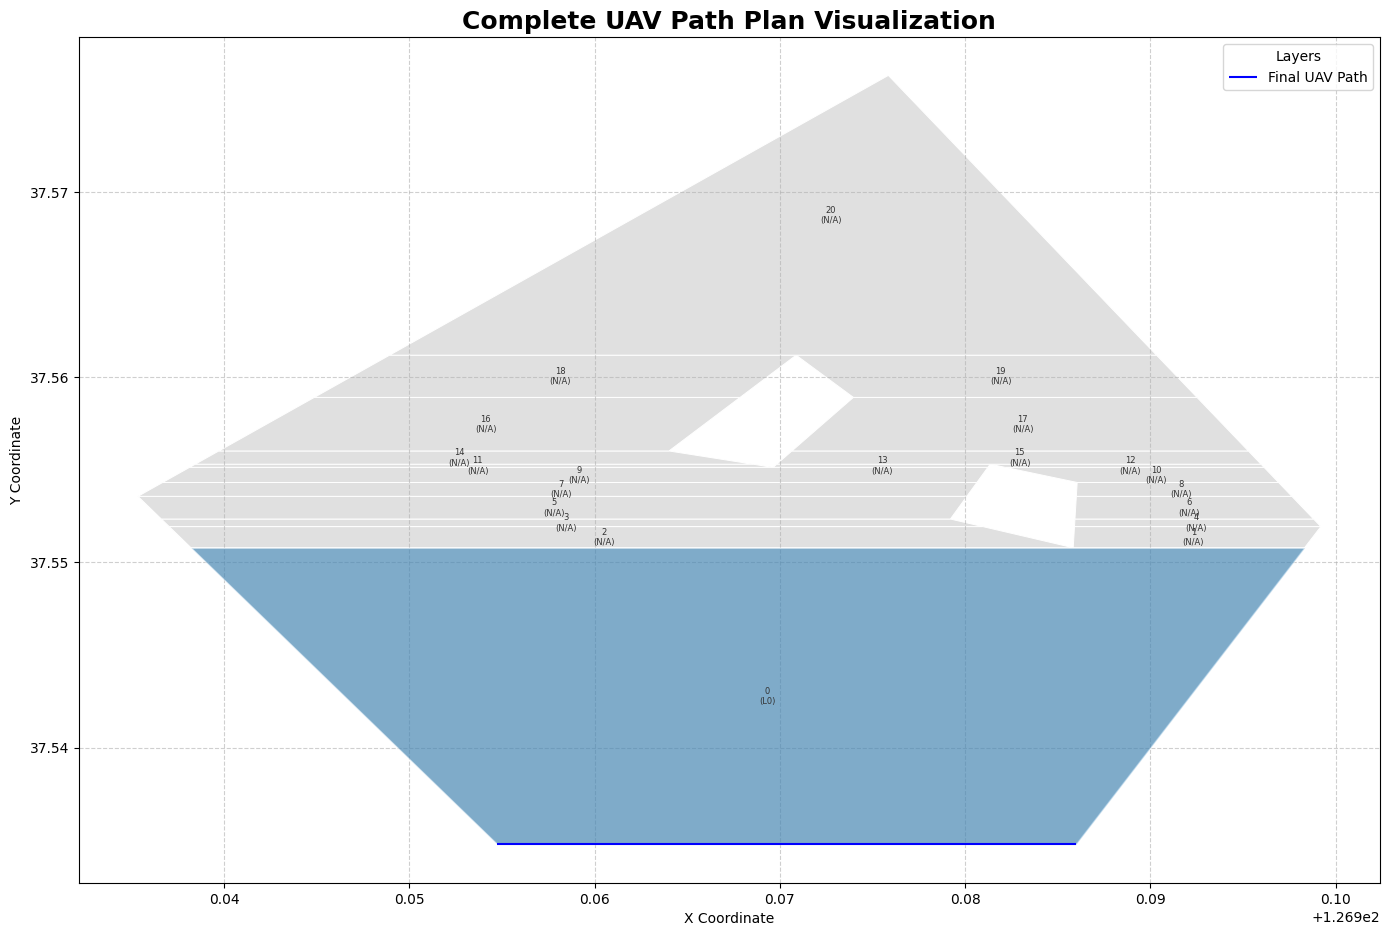

In [5]:
"""
DecomposeAndMerge (with User-Provided 'lawnmower' function - FIXED)

This version replaces the original lawnmower path generator with the user's
concise implementation for horizontal paths, including a fix for the
'MultiLineString' TypeError.

Requirements:
  - shapely, numpy, pandas, geopandas, matplotlib

Usage:
  python generate_final_path_user_lawnmower_fixed.py
"""

import json
import math
import collections
import heapq
from dataclasses import dataclass
from typing import List, Tuple, Dict, Set, Any

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString, box, mapping, Point
from shapely.ops import unary_union
from shapely.affinity import rotate


# ------------------------- Geometry helpers (No Changes) -------------------------
def polygon_internal_angles(poly: Polygon):
    coords = list(poly.exterior.coords)[:-1]; n = len(coords)
    def angle(a, b, c):
        ax, ay = a; bx, by = b; cx, cy = c
        v1 = np.array([ax - bx, ay - by]); v2 = np.array([cx - bx, cy - by])
        n1 = np.linalg.norm(v1) + 1e-12; n2 = np.linalg.norm(v2) + 1e-12
        v1 = v1 / n1; v2 = v2 / n2
        dot = np.clip(np.dot(v1, v2), -1.0, 1.0); ang = math.degrees(math.acos(dot))
        cross = v1[0] * v2[1] - v1[1] * v2[0]
        if cross < 0: ang = 360 - ang
        return ang
    return [angle(coords[(i - 1) % n], coords[i], coords[(i + 1) % n]) for i in range(n)]

def Convex(poly: Polygon, angle_tol: float = 1e-6) -> bool:
    if poly.is_empty or (not poly.is_valid) or len(poly.interiors) > 0: return False
    for ang in polygon_internal_angles(poly):
        if ang > 180 + angle_tol: return False
    return True

def SharedEdgeLen(p: Polygon, q: Polygon) -> float:
    inter = p.boundary.intersection(q.boundary)
    if inter.is_empty: return 0.0
    if isinstance(inter, LineString): return inter.length
    length = 0.0
    for g in getattr(inter, "geoms", []):
        if isinstance(g, LineString): length += g.length
    return length

# ------------------------- Partition & Graph build (No Changes) -------------------------
def all_vertex_y_levels(geom) -> List[float]:
    ys = []; geoms = getattr(geom, 'geoms', [geom])
    for g in geoms:
        if isinstance(g, Polygon):
            ys.extend(np.array(g.exterior.coords)[:, 1])
            for ring in g.interiors: ys.extend(np.array(ring.coords)[:, 1])
    return sorted(list(set(ys)))

def PartitionHorizontal(A: Polygon, H: List[Polygon]) -> List[Polygon]:
    free = A.difference(unary_union(H)) if H else A
    if free.is_empty: return []
    ys = all_vertex_y_levels(free); minx, _, maxx, _ = free.bounds
    parts: List[Polygon] = []
    for i in range(len(ys) - 1):
        y0, y1 = ys[i], ys[i + 1]
        if y1 <= y0 + 1e-9: continue
        slab = box(minx - 1.0, y0, maxx + 1.0, y1); inter = free.intersection(slab)
        if not inter.is_empty:
            if isinstance(inter, Polygon): parts.append(inter)
            else:
                for g in getattr(inter, "geoms", []):
                    if isinstance(g, Polygon): parts.append(g)
    return parts

def BuildAdjacency(parts: List[Polygon], min_shared: float) -> Dict[int, Set[int]]:
    N = len(parts); adj: Dict[int, Set[int]] = {i: set() for i in range(N)}
    for i in range(N):
        for j in range(i + 1, N):
            if SharedEdgeLen(parts[i], parts[j]) > min_shared:
                adj[i].add(j); adj[j].add(i)
    return adj

# ------------------------- Level-Constrained DFS & Segmentation (No Changes) -------------------------
def DFS_Order_With_Levels(adj: Dict[int, Set[int]], root: int, N: int) -> Tuple[List[int], List[int]]:
    if N == 0: return [], []
    levels = [-1] * N
    if root < N:
        levels[root] = 0
        queue = collections.deque([root]); visited_for_level = {root}
        while queue:
            u = queue.popleft()
            for v in sorted(list(adj.get(u, set()))):
                if v not in visited_for_level:
                    visited_for_level.add(v); levels[v] = levels[u] + 1; queue.append(v)
    order: List[int] = []; visited_for_dfs = [False] * N
    if root < N:
        stack = [root]; visited_for_dfs[root] = True
        while stack:
            u = stack.pop(); order.append(u)
            for v in sorted(list(adj.get(u, set())), reverse=True):
                if not visited_for_dfs[v] and levels[v] > levels[u]:
                    visited_for_dfs[v] = True; stack.append(v)
    return order, levels

@dataclass
class Segment:
    valid: bool; node_range: Tuple[int, int]; nodes: List[int]; edges: List[Tuple[int, int]]

def GenerateSegmentsFromPath(order: List[int], adj: Dict[int, Set[int]], levels: List[int]) -> List[Segment]:
    if not order: return []
    all_segments_nodes: List[List[int]] = []
    current_segment_nodes = [order[0]]
    for i in range(len(order) - 1):
        u, v = order[i], order[i+1]
        is_continuous_branch = (v in adj.get(u, set())) and (levels[v] > levels[u])
        if is_continuous_branch:
            current_segment_nodes.append(v)
        else:
            all_segments_nodes.append(current_segment_nodes)
            current_segment_nodes = [v]
    all_segments_nodes.append(current_segment_nodes)
    final_segments: List[Segment] = []
    for nodes in all_segments_nodes:
        if not nodes: continue
        node_range = (nodes[0], nodes[-1])
        edges = []
        for i in range(len(nodes) - 1):
            u, v = nodes[i], nodes[i+1]
            if v in adj.get(u, set()): edges.append((u,v))
        final_segments.append(Segment(True, node_range, nodes, edges))
    return final_segments

# ------------------------- Merge (No Changes) -------------------------
def MergeSegment(parts: List[Polygon], seg_nodes: List[int], seg_edges: List[Tuple[int, int]], angle_tol: float) -> List[Polygon]:
    if not seg_nodes: return []
    poly_map: Dict[int, Polygon] = {nid: parts[nid] for nid in seg_nodes}
    adj: Dict[int, Set[int]] = {nid: set() for nid in seg_nodes}
    for (u, v) in seg_edges:
        if u in adj and v in adj: adj[u].add(v); adj[v].add(u)
    changed = True
    while changed and len(poly_map) > 1:
        changed = False
        current_nodes = [n for n in seg_nodes if n in poly_map]
        for i in range(len(current_nodes) - 1):
            u, v = current_nodes[i], current_nodes[i+1]
            if v not in adj.get(u, set()): continue
            pu, pv = poly_map[u], poly_map[v]
            if SharedEdgeLen(pu, pv) <= 1e-6: continue
            U = unary_union([pu, pv])
            if isinstance(U, Polygon) and Convex(U, angle_tol):
                poly_map[u] = U
                del poly_map[v]
                v_neighbors = list(adj.pop(v, set()))
                for w in v_neighbors:
                    if w in adj:
                        adj[w].discard(v)
                        if w != u: adj[w].add(u); adj[u].add(w)
                changed = True
                break
    return list(poly_map.values())

# ------------------------- Path Generation and Connection (MODIFIED) -------------------------
# User-provided lawnmower function (FIXED)
def lawnmower(poly_xy: Polygon, spacing_m: float) -> list[tuple[float,float]]:
    """poly_xy: 로컬 좌표계(미터) 폴리곤, 반환: [(x,y), ...]"""
    minx, miny, maxx, maxy = poly_xy.bounds
    y = miny
    flip = False
    path_xy = []
    while y <= maxy:
        seg = LineString([(minx, y), (maxx, y)]).intersection(poly_xy)
        if not seg.is_empty:
            if hasattr(seg, "geoms"):
                # --- FIX: Use seg.geoms which is iterable ---
                seg = max(seg.geoms, key=lambda s: s.length)
            coords = list(seg.coords)
            if flip: coords.reverse()
            path_xy.extend(coords)
        y += spacing_m
        flip = not flip
    return path_xy

def find_path_between_parts(start_idx: int, end_idx: int, adj: Dict[int, Set[int]]) -> List[int]:
    """Finds the shortest path of part indices between two parts using BFS."""
    if start_idx == end_idx:
        return [start_idx]
    
    queue = collections.deque([[start_idx]])
    visited = {start_idx}
    
    while queue:
        path = queue.popleft()
        node = path[-1]
        
        if node == end_idx:
            return path
            
        for neighbor in sorted(list(adj.get(node, set()))):
            if neighbor not in visited:
                visited.add(neighbor)
                new_path = list(path)
                new_path.append(neighbor)
                queue.append(new_path)
    return [] # Path not found

def connect_paths(paths: List[LineString], parts: List[Polygon], adj: Dict[int, Set[int]]) -> LineString:
    if not paths: return LineString()
    
    part_points = [p.representative_point() for p in parts]
    full_path_coords = []
    current_path = paths[0]
    full_path_coords.extend(list(current_path.coords))
    
    for i in range(1, len(paths)):
        last_point = Point(full_path_coords[-1])
        next_path = paths[i]
        
        start_part_idx = -1
        for j, p in enumerate(parts):
            if p.contains(last_point):
                start_part_idx = j
                break
        
        start_next_point = Point(next_path.coords[0])
        end_next_point = Point(next_path.coords[-1])
        if last_point.distance(start_next_point) > last_point.distance(end_next_point):
            coords = list(next_path.coords); coords.reverse()
            next_path = LineString(coords)
            start_next_point = Point(next_path.coords[0])
            
        end_part_idx = -1
        for j, p in enumerate(parts):
            if p.contains(start_next_point):
                end_part_idx = j
                break
        
        if start_part_idx != -1 and end_part_idx != -1:
            part_indices_path = find_path_between_parts(start_part_idx, end_part_idx, adj)
            if part_indices_path:
                transition_coords = [part_points[idx].coords[0] for idx in part_indices_path]
                full_path_coords.append(transition_coords[0])
                full_path_coords.extend(transition_coords)
                full_path_coords.append(start_next_point.coords[0])

        full_path_coords.extend(list(next_path.coords))
        
    return LineString(full_path_coords)

# ------------------------- Main algorithm (No Changes) -------------------------
def DecomposeAndMerge(A: Polygon, H: List[Polygon], min_shared: float, angle_tol: float, root: int = 0) -> Dict[str, Any]:
    parts = PartitionHorizontal(A, H)
    adj = BuildAdjacency(parts, min_shared)
    order, levels = DFS_Order_With_Levels(adj, root, len(parts))
    segments = GenerateSegmentsFromPath(order, adj, levels)
    merged_segments: List[List[Polygon]] = []
    for seg in segments:
        if seg.valid: Ms = MergeSegment(parts, seg.nodes[:], seg.edges[:], angle_tol)
        else: Ms = []
        merged_segments.append(Ms)
    return {
        "parts": parts, "adj": adj, "order": order, "levels": levels,
        "segments": segments, "merged_segments": merged_segments,
    }

# ------------------------- Demo File Creation (No Changes) -------------------------
def create_demo_geojson(filepath="demo_area.geojson"):
    A = Polygon([
            (126.975861, 37.576283),
            (126.935349, 37.553560),
            (126.954746, 37.534777),
            (126.985989, 37.534777),
            (126.999207, 37.551927)
        ])

    H = [
        Polygon([
            (126.970882, 37.561180),
            (126.964016, 37.556009),
            (126.969638, 37.555125),
            (126.973972, 37.558901)
        ]),
        Polygon([
            (126.981354, 37.555295),
            (126.979208, 37.552335),
            (126.985838, 37.550787),
            (126.986053, 37.554308)
        ])
    ]
    features = [{"type": "Feature", "properties": {"type": "area"}, "geometry": mapping(A)}]
    for i, h_poly in enumerate(H):
        features.append({"type": "Feature", "properties": {"type": "hole", "id": i}, "geometry": mapping(h_poly)})
    fc = {"type": "FeatureCollection", "features": features}
    with open(filepath, "w", encoding="utf-8") as f: json.dump(fc, f, ensure_ascii=False, indent=2)
    print(f"✅ Demo file '{filepath}' created successfully.")

# ------------------------- Visualization (No Changes) -------------------------
def visualize_results(result: Dict[str, Any], final_path: LineString):
    parts = result["parts"]; segments = result["segments"]; order = result["order"]; levels = result["levels"]
    fig, ax = plt.subplots(figsize=(14, 11))
    gpd.GeoSeries(parts).plot(ax=ax, color='#e0e0e0', edgecolor='white', linewidth=0.7, zorder=1)
    colors = plt.cm.get_cmap('tab10', len(segments))
    for i, seg in enumerate(segments):
        if not seg.valid: continue
        seg_polys = [parts[node_id] for node_id in seg.nodes if node_id < len(parts)]
        if not seg_polys: continue
        seg_union = unary_union(seg_polys)
        label = f"Segment {i+1}"
        gpd.GeoSeries([seg_union]).plot(ax=ax, color=colors(i), edgecolor='white', alpha=0.5, zorder=2, label=label)
    for i, p in enumerate(parts):
        point = p.representative_point()
        level = levels[i]
        label = f"{i}\n(L{level})" if level != -1 else f"{i}\n(N/A)"
        ax.text(point.x, point.y, label, fontsize=6, ha='center', va='center', color='#333333', zorder=4)
    points = {i: p.representative_point() for i, p in enumerate(parts)}
    for i in range(len(order) - 1):
        u, v = order[i], order[i+1]
        if u in points and v in points:
            p_start = points[u]; p_end = points[v]
            ax.annotate("", xy=(p_end.x, p_end.y), xytext=(p_start.x, p_start.y),
                        arrowprops=dict(arrowstyle="->", color="red", lw=1.0, shrinkA=5, shrinkB=5), zorder=3)
    if final_path:
        gpd.GeoSeries([final_path]).plot(ax=ax, color='blue', linewidth=1.5, zorder=5, label="Final UAV Path")
    ax.set_title("Complete UAV Path Plan Visualization", fontsize=18, fontweight='bold')
    ax.set_xlabel("X Coordinate"); ax.set_ylabel("Y Coordinate")
    ax.set_aspect('equal', adjustable='box'); ax.legend(title="Layers")
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()

# ------------------------- Main script execution (MODIFIED to use 'lawnmower') -------------------------
def main():
    geojson_path = "demo_area.geojson"; create_demo_geojson(geojson_path)
    gdf = gpd.read_file(geojson_path)
    A = gdf[gdf['type'] == 'area'].geometry.iloc[0]; H = list(gdf[gdf['type'] == 'hole'].geometry)
    print("\n🚀 Running DecomposeAndMerge...")
    result = DecomposeAndMerge(A, H, min_shared=5.0, angle_tol=1e-6, root=0)
    print("...Decomposition and merging finished.")
    print("🌿 Generating lawnmower paths...")
    path_spacing = 60.0
    all_individual_paths = []
    merged_polygons_in_order = [p for sublist in result['merged_segments'] for p in sublist]
    for poly in merged_polygons_in_order:
        # --- CHANGE: Using the new 'lawnmower' function ---
        path_coords = lawnmower(poly, spacing_m=path_spacing)
        # Convert list of coords back to LineString for the rest of the system
        if len(path_coords) > 1:
            path = LineString(path_coords)
            all_individual_paths.append(path)
        # ---------------------------------------------------
    print(f"...Generated {len(all_individual_paths)} individual paths.")
    
    print("🔗 Connecting all paths with obstacle avoidance...")
    final_path = connect_paths(all_individual_paths, result['parts'], result['adj'])
    print("...Final path created.")
    
    print("📊 Generating visualization...")
    visualize_results(result, final_path)

if __name__ == "__main__":
    main()

✅ Demo file 'demo_area.geojson' created successfully.

🚀 Running DecomposeAndMerge...
...Decomposition and merging finished.
🌿 Stage 1: Generating continuous paths within each segment...
...Created 3 continuous segment paths.
🔗 Stage 2: Connecting all segment paths into a final trajectory...
...Final path created.
📊 Generating visualization...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 0 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(
/var/folders/w9/_qn43d_j5l37kv2ls_rf5z9m0000gn/T/ipykernel_16094/2385889692.py:301: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(segments))
/var/folders/w9/_qn43d_j5l37kv2ls_rf5z9m0000gn/T/ipykernel_16094/2385889692.py:325: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.set_aspect('equal', adjustable='box'); ax.legend(title="Layers")


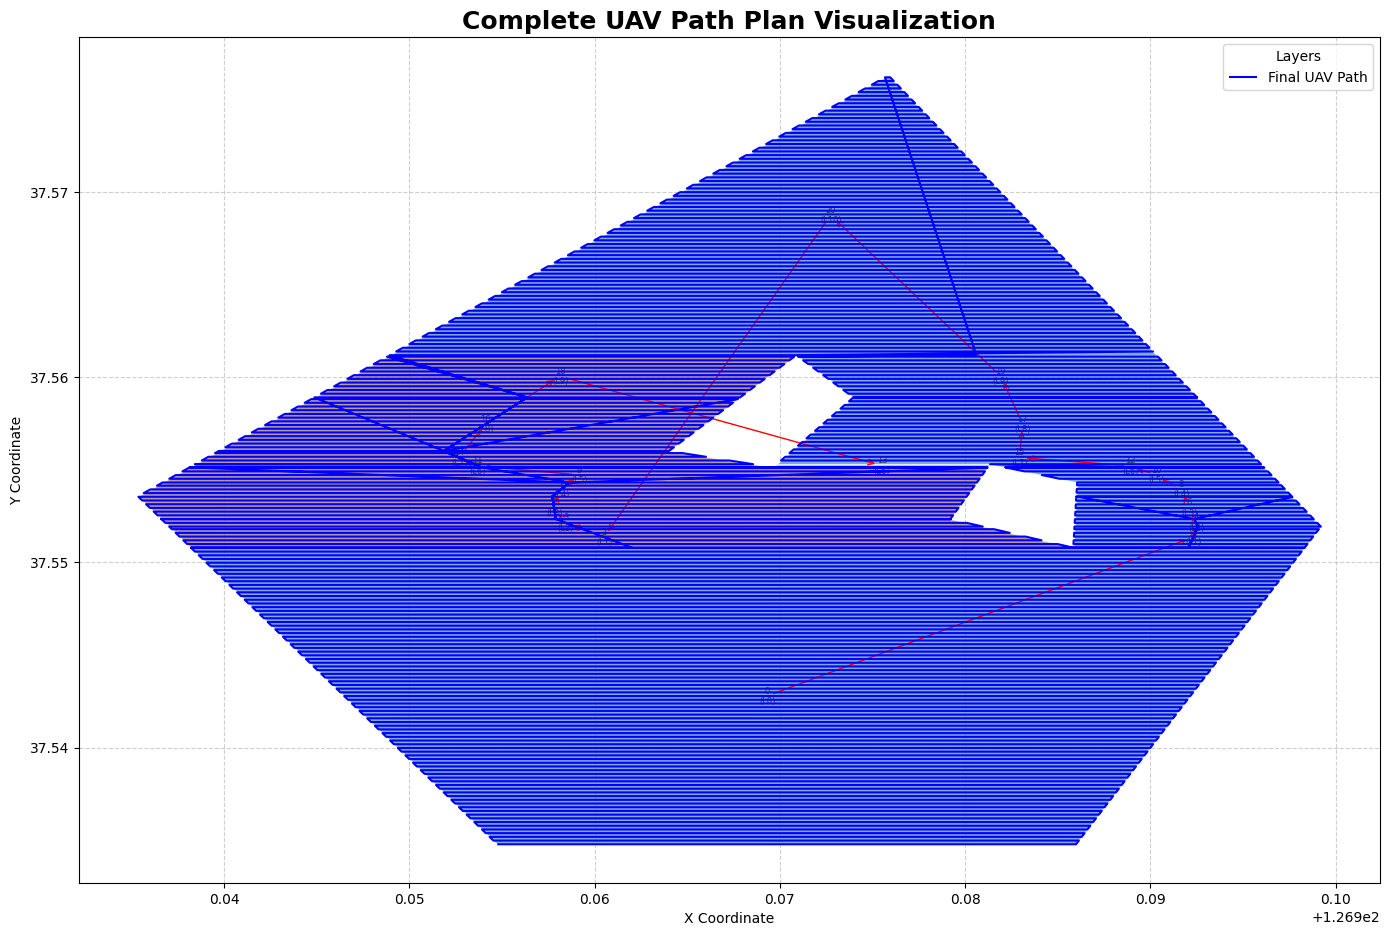

In [24]:
"""
DecomposeAndMerge (Using User-Provided 'lawnmower' function)

This version replaces the original lawnmower path generator with the user's
more concise implementation for horizontal paths.

Requirements:
  - shapely, numpy, pandas, geopandas, matplotlib

Usage:
  python generate_final_path_user_lawnmower.py
"""

import json
import math
import collections
import heapq
from dataclasses import dataclass
from typing import List, Tuple, Dict, Set, Any

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString, box, mapping, Point
from shapely.ops import unary_union
from shapely.affinity import rotate


# ------------------------- Geometry helpers (No Changes) -------------------------
def polygon_internal_angles(poly: Polygon):
    coords = list(poly.exterior.coords)[:-1]; n = len(coords)
    def angle(a, b, c):
        ax, ay = a; bx, by = b; cx, cy = c
        v1 = np.array([ax - bx, ay - by]); v2 = np.array([cx - bx, cy - by])
        n1 = np.linalg.norm(v1) + 1e-12; n2 = np.linalg.norm(v2) + 1e-12
        v1 = v1 / n1; v2 = v2 / n2
        dot = np.clip(np.dot(v1, v2), -1.0, 1.0); ang = math.degrees(math.acos(dot))
        cross = v1[0] * v2[1] - v1[1] * v2[0]
        if cross < 0: ang = 360 - ang
        return ang
    return [angle(coords[(i - 1) % n], coords[i], coords[(i + 1) % n]) for i in range(n)]

def Convex(poly: Polygon, angle_tol: float = 1e-6) -> bool:
    if poly.is_empty or (not poly.is_valid) or len(poly.interiors) > 0: return False
    for ang in polygon_internal_angles(poly):
        if ang > 180 + angle_tol: return False
    return True

# ------------------------- Partition & Graph build (No Changes) -------------------------
def all_vertex_y_levels(geom) -> List[float]:
    ys = []; geoms = getattr(geom, 'geoms', [geom])
    for g in geoms:
        if isinstance(g, Polygon):
            ys.extend(np.array(g.exterior.coords)[:, 1])
            for ring in g.interiors: ys.extend(np.array(ring.coords)[:, 1])
    return sorted(list(set(ys)))

def PartitionHorizontal(A: Polygon, H: List[Polygon]) -> List[Polygon]:
    free = A.difference(unary_union(H)) if H else A
    if free.is_empty: return []
    ys = all_vertex_y_levels(free); minx, _, maxx, _ = free.bounds
    parts: List[Polygon] = []
    for i in range(len(ys) - 1):
        y0, y1 = ys[i], ys[i + 1]
        if y1 <= y0 + 1e-9: continue
        slab = box(minx - 1.0, y0, maxx + 1.0, y1); inter = free.intersection(slab)
        if not inter.is_empty:
            if isinstance(inter, Polygon): parts.append(inter)
            else:
                for g in getattr(inter, "geoms", []):
                    if isinstance(g, Polygon): parts.append(g)
    return parts

def BuildAdjacency(parts: List[Polygon], min_shared: float) -> Dict[int, Set[int]]:
    N = len(parts); adj: Dict[int, Set[int]] = {i: set() for i in range(N)}
    for i in range(N):
        for j in range(i + 1, N):
            inter = parts[i].boundary.intersection(parts[j].boundary)
            if not inter.is_empty and inter.length > min_shared:
                adj[i].add(j); adj[j].add(i)
    return adj

# ------------------------- Level-Constrained DFS & Segmentation (No Changes) -------------------------
def DFS_Order_With_Levels(adj: Dict[int, Set[int]], root: int, N: int) -> Tuple[List[int], List[int]]:
    if N == 0: return [], []
    levels = [-1] * N
    if root < N:
        levels[root] = 0; queue = collections.deque([root]); visited_for_level = {root}
        while queue:
            u = queue.popleft()
            for v in sorted(list(adj.get(u, set()))):
                if v not in visited_for_level:
                    visited_for_level.add(v); levels[v] = levels[u] + 1; queue.append(v)
    order: List[int] = []; visited_for_dfs = [False] * N
    if root < N:
        stack = [root]; visited_for_dfs[root] = True
        while stack:
            u = stack.pop(); order.append(u)
            for v in sorted(list(adj.get(u, set())), reverse=True):
                if not visited_for_dfs[v] and levels[v] > levels[u]:
                    visited_for_dfs[v] = True; stack.append(v)
    return order, levels

@dataclass
class Segment:
    valid: bool; node_range: Tuple[int, int]; nodes: List[int]; edges: List[Tuple[int, int]]

def GenerateSegmentsFromPath(order: List[int], adj: Dict[int, Set[int]], levels: List[int]) -> List[Segment]:
    if not order: return []
    all_segments_nodes: List[List[int]] = []
    current_segment_nodes = [order[0]]
    for i in range(len(order) - 1):
        u, v = order[i], order[i+1]
        is_continuous_branch = (v in adj.get(u, set())) and (levels[v] > levels[u])
        if is_continuous_branch: current_segment_nodes.append(v)
        else: all_segments_nodes.append(current_segment_nodes); current_segment_nodes = [v]
    all_segments_nodes.append(current_segment_nodes)
    final_segments: List[Segment] = []
    for nodes in all_segments_nodes:
        if not nodes: continue
        node_range = (nodes[0], nodes[-1]); edges = []
        for i in range(len(nodes) - 1):
            u, v = nodes[i], nodes[i+1]
            if v in adj.get(u, set()): edges.append((u,v))
        final_segments.append(Segment(True, node_range, nodes, edges))
    return final_segments

def MergeSegment(parts: List[Polygon], seg_nodes: List[int], seg_edges: List[Tuple[int, int]], angle_tol: float) -> List[Polygon]:
    if not seg_nodes: return []
    poly_map: Dict[int, Polygon] = {nid: parts[nid] for nid in seg_nodes}
    adj: Dict[int, Set[int]] = {nid: set() for nid in seg_nodes}
    for (u, v) in seg_edges:
        if u in adj and v in adj: adj[u].add(v); adj[v].add(u)
    changed = True
    while changed and len(poly_map) > 1:
        changed = False
        current_nodes = [n for n in seg_nodes if n in poly_map]
        for i in range(len(current_nodes) - 1):
            u, v = current_nodes[i], current_nodes[i+1]
            if v not in adj.get(u, set()): continue
            pu, pv = poly_map[u], poly_map[v]
            U = unary_union([pu, pv])
            if isinstance(U, Polygon) and Convex(U, angle_tol):
                poly_map[u] = U; del poly_map[v]
                v_neighbors = list(adj.pop(v, set()))
                for w in v_neighbors:
                    if w in adj:
                        adj[w].discard(v)
                        if w != u: adj[w].add(u); adj[u].add(w)
                changed = True
                break
    return list(poly_map.values())

# ------------------------- Path Generation and Robust Connection (MODIFIED) -------------------------
# NEW: User-provided lawnmower function
def lawnmower(poly_xy: Polygon, spacing_m: float) -> list[tuple[float,float]]:
    """poly_xy: 로컬 좌표계(미터) 폴리곤, 반환: [(x,y), ...]"""
    minx, miny, maxx, maxy = poly_xy.bounds
    y = miny
    flip = False
    path_xy = []
    while y <= maxy:
        seg = LineString([(minx, y), (maxx, y)]).intersection(poly_xy)
        if not seg.is_empty:
            if hasattr(seg, "geoms"):
                seg = max(seg.geoms, key=lambda s: s.length)
            coords = list(seg.coords)
            if flip: coords.reverse()
            path_xy.extend(coords)
        y += spacing_m
        flip = not flip
    return path_xy

def build_transition_graph(parts: List[Polygon], adj: Dict[int, Set[int]]):
    node_coords = {}; graph = collections.defaultdict(list); edge_midpoints = {}
    node_id_counter = 0
    for p1_idx, neighbors in adj.items():
        for p2_idx in neighbors:
            if p1_idx >= p2_idx: continue
            edge = tuple(sorted((p1_idx, p2_idx)))
            if edge not in edge_midpoints:
                shared_geom = parts[p1_idx].boundary.intersection(parts[p2_idx].boundary)
                if not shared_geom.is_empty:
                    midpoint = shared_geom.centroid
                    node_coords[node_id_counter] = (midpoint.x, midpoint.y)
                    edge_midpoints[edge] = node_id_counter
                    node_id_counter += 1
    for part_idx, part_poly in enumerate(parts):
        part_doorways = []
        for neighbor_idx in adj.get(part_idx, set()):
            edge = tuple(sorted((part_idx, neighbor_idx)))
            if edge in edge_midpoints: part_doorways.append(edge_midpoints[edge])
        for i in range(len(part_doorways)):
            for j in range(i + 1, len(part_doorways)):
                u, v = part_doorways[i], part_doorways[j]
                p1 = Point(node_coords[u]); p2 = Point(node_coords[v])
                dist = p1.distance(p2)
                graph[u].append((v, dist)); graph[v].append((u, dist))
    return graph, node_coords, edge_midpoints

def dijkstra_path(graph, node_coords, start_node, end_node):
    pq = [(0, start_node, [])]; visited = set()
    while pq:
        dist, current_node, path = heapq.heappop(pq)
        if current_node in visited: continue
        visited.add(current_node)
        path = path + [current_node]
        if current_node == end_node: return [node_coords[n] for n in path]
        for neighbor, weight in graph.get(current_node, []):
            if neighbor not in visited:
                heapq.heappush(pq, (dist + weight, neighbor, path))
    return []

def connect_paths_robust(paths: List[LineString], parts: List[Polygon], adj: Dict[int, Set[int]], nav_graph_data) -> LineString:
    if len(paths) <= 1: return paths[0] if paths else LineString()
    graph, node_coords, edge_midpoints = nav_graph_data
    node_id_counter = len(node_coords)
    full_path_coords = []
    current_path = paths[0]
    full_path_coords.extend(list(current_path.coords))
    for i in range(1, len(paths)):
        last_point = Point(full_path_coords[-1])
        next_path = paths[i]
        start_next_point = Point(next_path.coords[0])
        start_part_idx = next((j for j, p in enumerate(parts) if p.buffer(1e-9).contains(last_point)), -1)
        end_part_idx = next((j for j, p in enumerate(parts) if p.buffer(1e-9).contains(start_next_point)), -1)
        if start_part_idx != -1 and end_part_idx != -1 and start_part_idx != end_part_idx:
            temp_graph = {k: v[:] for k, v in graph.items()}; temp_node_coords = node_coords.copy()
            start_node_id, end_node_id = node_id_counter, node_id_counter + 1
            temp_node_coords[start_node_id] = (last_point.x, last_point.y)
            temp_node_coords[end_node_id] = (start_next_point.x, start_next_point.y)
            for neighbor_idx in adj.get(start_part_idx, set()):
                edge = tuple(sorted((start_part_idx, neighbor_idx)))
                if edge in edge_midpoints:
                    doorway_id = edge_midpoints[edge]
                    dist = last_point.distance(Point(temp_node_coords[doorway_id]))
                    temp_graph.setdefault(start_node_id, []).append((doorway_id, dist))
                    temp_graph.setdefault(doorway_id, []).append((start_node_id, dist))
            for neighbor_idx in adj.get(end_part_idx, set()):
                edge = tuple(sorted((end_part_idx, neighbor_idx)))
                if edge in edge_midpoints:
                    doorway_id = edge_midpoints[edge]
                    dist = start_next_point.distance(Point(temp_node_coords[doorway_id]))
                    temp_graph.setdefault(end_node_id, []).append((doorway_id, dist))
                    temp_graph.setdefault(doorway_id, []).append((end_node_id, dist))
            transition_coords = dijkstra_path(temp_graph, temp_node_coords, start_node_id, end_node_id)
            if transition_coords: full_path_coords.extend(transition_coords[1:-1])
        full_path_coords.extend(list(next_path.coords))
    return LineString(full_path_coords)

# ------------------------- Main algorithm & Demo (No Changes) -------------------------
def DecomposeAndMerge(A: Polygon, H: List[Polygon], min_shared: float, angle_tol: float, root: int = 0) -> Dict[str, Any]:
    parts = PartitionHorizontal(A, H)
    adj = BuildAdjacency(parts, min_shared)
    order, levels = DFS_Order_With_Levels(adj, root, len(parts))
    segments = GenerateSegmentsFromPath(order, adj, levels)
    merged_segments: List[List[Polygon]] = []
    for seg in segments:
        if seg.valid: Ms = MergeSegment(parts, seg.nodes[:], seg.edges[:], angle_tol)
        else: Ms = []
        merged_segments.append(Ms)
    return { "parts": parts, "adj": adj, "order": order, "levels": levels,
             "segments": segments, "merged_segments": merged_segments }

def create_demo_geojson(filepath="demo_area.geojson"):
    A = Polygon([
            (126.975861, 37.576283),
            (126.935349, 37.553560),
            (126.954746, 37.534777),
            (126.985989, 37.534777),
            (126.999207, 37.551927)
        ])

    H = [
        Polygon([
            (126.970882, 37.561180),
            (126.964016, 37.556009),
            (126.969638, 37.555125),
            (126.973972, 37.558901)
        ]),
        Polygon([
            (126.981354, 37.555295),
            (126.979208, 37.552335),
            (126.985838, 37.550787),
            (126.986053, 37.554308)
        ])
    ]
    features = [{"type": "Feature", "properties": {"type": "area"}, "geometry": mapping(A)}]
    for i, h_poly in enumerate(H):
        features.append({"type": "Feature", "properties": {"type": "hole", "id": i}, "geometry": mapping(h_poly)})
    fc = {"type": "FeatureCollection", "features": features}
    with open(filepath, "w", encoding="utf-8") as f: json.dump(fc, f, ensure_ascii=False, indent=2)
    print(f"✅ Demo file '{filepath}' created successfully.")

# ------------------------- Visualization (No Changes) -------------------------
def visualize_results(result: Dict[str, Any], final_path: LineString):
    parts = result["parts"]; segments = result["segments"]; order = result["order"]; levels = result["levels"]
    fig, ax = plt.subplots(figsize=(14, 11))
    gpd.GeoSeries(parts).plot(ax=ax, color='#e0e0e0', edgecolor='white', linewidth=0.7, zorder=1)
    colors = plt.cm.get_cmap('tab10', len(segments))
    for i, seg in enumerate(segments):
        if not seg.valid: continue
        seg_polys = [parts[node_id] for node_id in seg.nodes if node_id < len(parts)]
        if not seg_polys: continue
        seg_union = unary_union(seg_polys)
        label = f"Segment {i+1}"
        gpd.GeoSeries([seg_union]).plot(ax=ax, color=colors(i), edgecolor='white', alpha=0.5, zorder=2, label=label)
    for i, p in enumerate(parts):
        point = p.representative_point()
        level = levels[i]
        label = f"{i}\n(L{level})" if level != -1 else f"{i}\n(N/A)"
        ax.text(point.x, point.y, label, fontsize=6, ha='center', va='center', color='#333333', zorder=4)
    points = {i: p.representative_point() for i, p in enumerate(parts)}
    for i in range(len(order) - 1):
        u, v = order[i], order[i+1]
        if u in points and v in points:
            p_start = points[u]; p_end = points[v]
            ax.annotate("", xy=(p_end.x, p_end.y), xytext=(p_start.x, p_start.y),
                        arrowprops=dict(arrowstyle="->", color="red", lw=1.0, shrinkA=5, shrinkB=5), zorder=3)
    if final_path:
        gpd.GeoSeries([final_path]).plot(ax=ax, color='blue', linewidth=1.5, zorder=5, label="Final UAV Path")
    ax.set_title("Complete UAV Path Plan Visualization", fontsize=18, fontweight='bold')
    ax.set_xlabel("X Coordinate"); ax.set_ylabel("Y Coordinate")
    ax.set_aspect('equal', adjustable='box'); ax.legend(title="Layers")
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()
    
def reorder_paths_nearest_neighbor(paths: List[LineString]) -> List[LineString]:
    if len(paths) <= 1: return paths
    unvisited_paths = list(paths); ordered_paths = []
    current_path = unvisited_paths.pop(0); ordered_paths.append(current_path)
    while unvisited_paths:
        last_point = Point(current_path.coords[-1]); best_dist = float('inf'); best_idx = -1; best_path_reversed = False
        for i, p in enumerate(unvisited_paths):
            start_p = Point(p.coords[0]); end_p = Point(p.coords[-1])
            dist_to_start = last_point.distance(start_p); dist_to_end = last_point.distance(end_p)
            if dist_to_start < best_dist: best_dist = dist_to_start; best_idx = i; best_path_reversed = False
            if dist_to_end < best_dist: best_dist = dist_to_end; best_idx = i; best_path_reversed = True
        next_path = unvisited_paths.pop(best_idx)
        if best_path_reversed: coords = list(next_path.coords); coords.reverse(); next_path = LineString(coords)
        ordered_paths.append(next_path); current_path = next_path
    return ordered_paths

# ------------------------- Main script execution (MODIFIED to use 'lawnmower') -------------------------
def main():
    geojson_path = "demo_area.geojson"; create_demo_geojson(geojson_path)
    gdf = gpd.read_file(geojson_path)
    A = gdf[gdf['type'] == 'area'].geometry.iloc[0]; H = list(gdf[gdf['type'] == 'hole'].geometry)
    
    print("\n🚀 Running DecomposeAndMerge...")
    result = DecomposeAndMerge(A, H, min_shared=0.0, angle_tol=1e-6, root=0)
    print("...Decomposition and merging finished.")
    
    print("🌿 Stage 1: Generating continuous paths within each segment...")
    path_spacing = 0.0002
    
    all_segment_super_paths = []
    nav_graph_data = build_transition_graph(result['parts'], result['adj'])

    for i, segment_info in enumerate(result['segments']):
        merged_polys_for_this_segment = []
        # Find which merged polygons belong to this segment
        # This is a complex mapping, we simplify by finding the containing merged_segment group
        if segment_info.nodes:
            first_node_in_seg = segment_info.nodes[0]
            for merged_poly_list in result['merged_segments']:
                if merged_poly_list and unary_union(merged_poly_list).buffer(1e-9).contains(result['parts'][first_node_in_seg]):
                    merged_polys_for_this_segment.extend(merged_poly_list)
                    break
        
        if not merged_polys_for_this_segment: continue

        individual_paths_in_segment = []
        for poly in merged_polys_for_this_segment:
            # --- CHANGE: Using the new 'lawnmower' function ---
            path_coords = lawnmower(poly, spacing_m=path_spacing)
            # Convert list of coords back to LineString for the rest of the system
            if len(path_coords) > 1:
                path = LineString(path_coords)
                individual_paths_in_segment.append(path)
            # ---------------------------------------------------

        if not individual_paths_in_segment: continue

        ordered_paths_in_segment = reorder_paths_nearest_neighbor(individual_paths_in_segment)
        segment_super_path = connect_paths_robust(ordered_paths_in_segment, result['parts'], result['adj'], nav_graph_data)
        
        if segment_super_path.length > 0:
            all_segment_super_paths.append(segment_super_path)
    
    print(f"...Created {len(all_segment_super_paths)} continuous segment paths.")

    print("🔗 Stage 2: Connecting all segment paths into a final trajectory...")
    final_path = connect_paths_robust(all_segment_super_paths, result['parts'], result['adj'], nav_graph_data)
    print("...Final path created.")
    
    print("📊 Generating visualization...")
    visualize_results(result, final_path)

if __name__ == "__main__":
    main()

✅ Demo file 'demo_area.geojson' created successfully.

🚀 Running DecomposeAndMerge...
...Decomposition and merging finished.
🌿 Stage 1: Generating paths per merged region...
...Created 3 continuous segment paths.
🔗 Stage 2: Connecting all segment paths into a final trajectory...
...Final path created.
📊 Generating separate visualizations...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 0 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


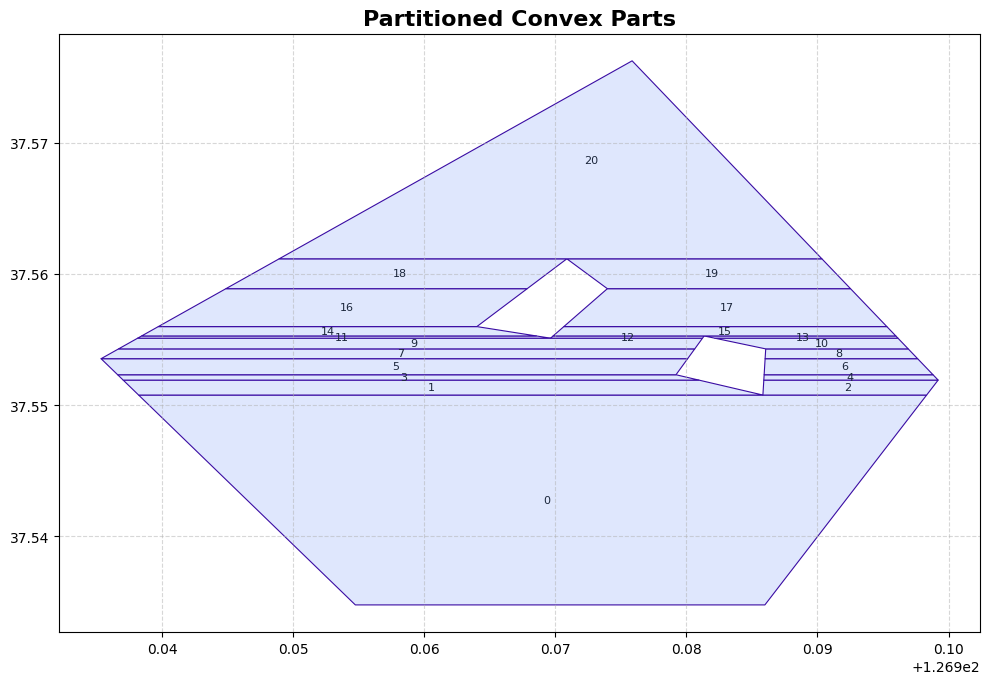

/var/folders/w9/_qn43d_j5l37kv2ls_rf5z9m0000gn/T/ipykernel_16094/1058526875.py:277: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', max(1, len(segments)))
/var/folders/w9/_qn43d_j5l37kv2ls_rf5z9m0000gn/T/ipykernel_16094/1058526875.py:295: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right'); ax.set_title("DFS-Based Segment Grouping & Order", fontsize=16, fontweight='bold')
/var/folders/w9/_qn43d_j5l37kv2ls_rf5z9m0000gn/T/ipykernel_16094/1058526875.py:295: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argum

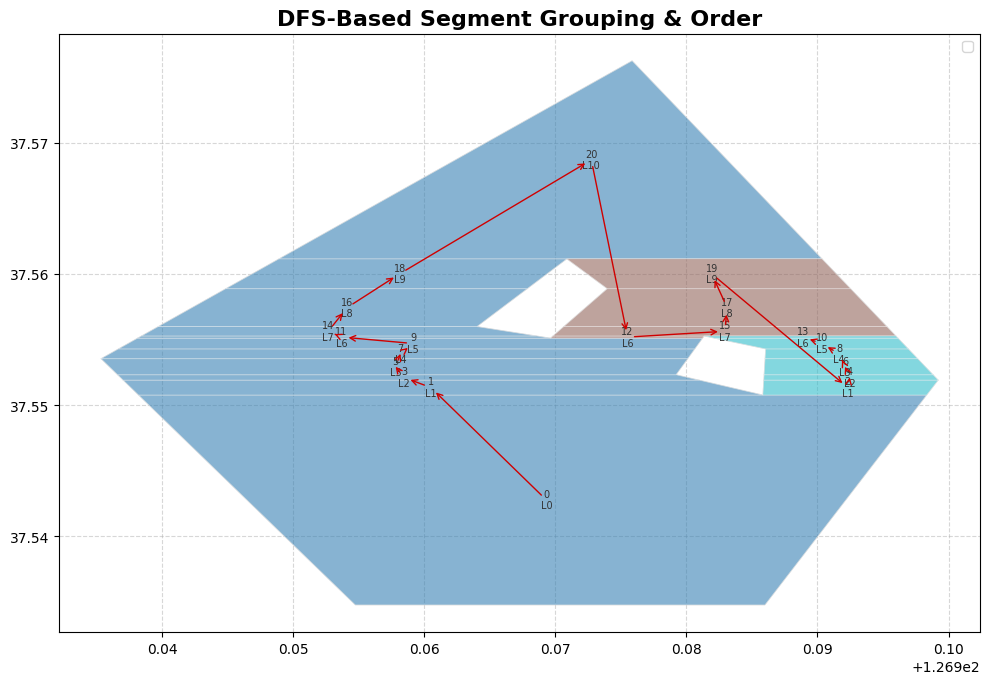

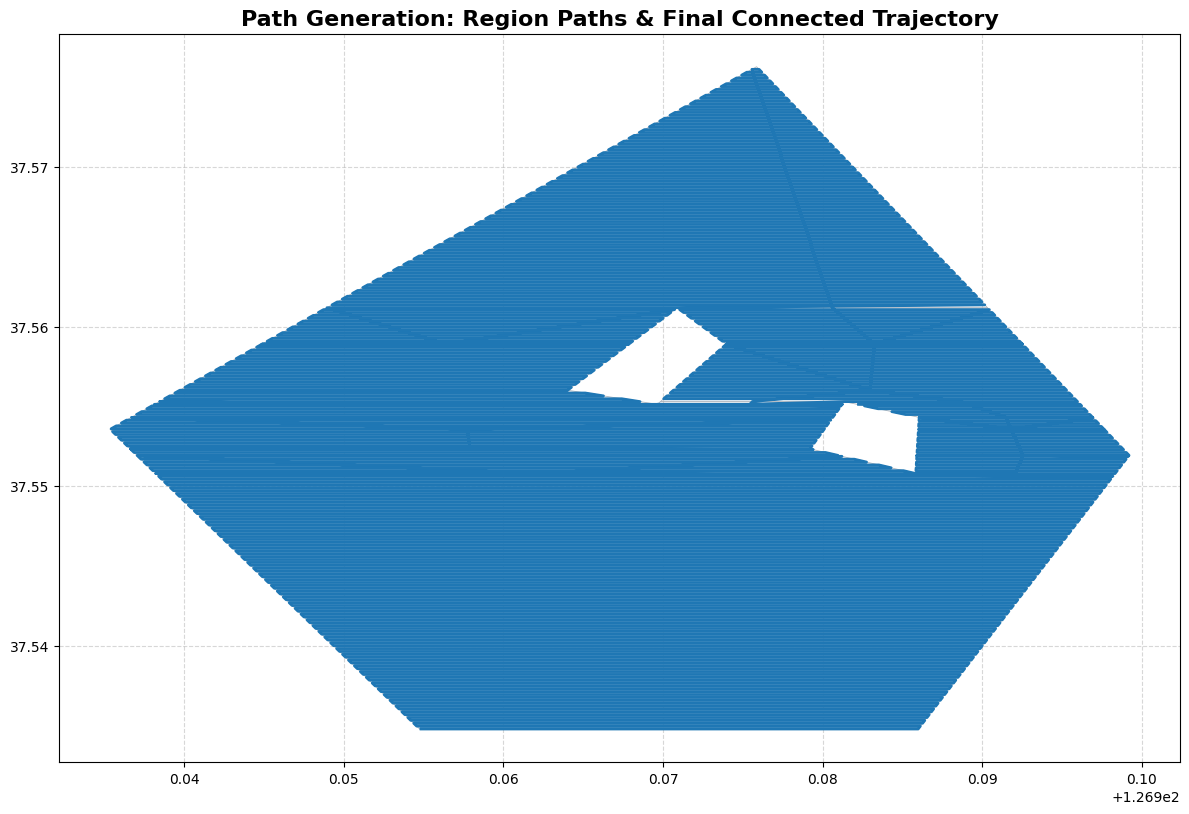

In [40]:
"""
DecomposeAndMerge (Using User-Provided 'lawnmower' function)

Adds separate visualizations for:
  1) Partitioned convex parts (after horizontal decomposition)
  2) DFS-based segment grouping and traversal order
  3) Path generation (per-merged-region paths + final connected path)

Requirements:
  - shapely, numpy, pandas, geopandas, matplotlib

Usage:
  python uav_path_visualizations_split.py
"""

import json
import math
import collections
import heapq
from dataclasses import dataclass
from typing import List, Tuple, Dict, Set, Any

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString, box, mapping, Point
from shapely.ops import unary_union
from shapely.affinity import rotate


# ------------------------- Geometry helpers (No Changes) -------------------------
def polygon_internal_angles(poly: Polygon):
    coords = list(poly.exterior.coords)[:-1]; n = len(coords)
    def angle(a, b, c):
        ax, ay = a; bx, by = b; cx, cy = c
        v1 = np.array([ax - bx, ay - by]); v2 = np.array([cx - bx, cy - by])
        n1 = np.linalg.norm(v1) + 1e-12; n2 = np.linalg.norm(v2) + 1e-12
        v1 = v1 / n1; v2 = v2 / n2
        dot = np.clip(np.dot(v1, v2), -1.0, 1.0); ang = math.degrees(math.acos(dot))
        cross = v1[0] * v2[1] - v1[1] * v2[0]
        if cross < 0: ang = 360 - ang
        return ang
    return [angle(coords[(i - 1) % n], coords[i], coords[(i + 1) % n]) for i in range(n)]

def Convex(poly: Polygon, angle_tol: float = 1e-6) -> bool:
    if poly.is_empty or (not poly.is_valid) or len(poly.interiors) > 0: return False
    for ang in polygon_internal_angles(poly):
        if ang > 180 + angle_tol: return False
    return True

# ------------------------- Partition & Graph build (No Changes) -------------------------
def all_vertex_y_levels(geom) -> List[float]:
    ys = []; geoms = getattr(geom, 'geoms', [geom])
    for g in geoms:
        if isinstance(g, Polygon):
            ys.extend(np.array(g.exterior.coords)[:, 1])
            for ring in g.interiors: ys.extend(np.array(ring.coords)[:, 1])
    return sorted(list(set(ys)))

def PartitionHorizontal(A: Polygon, H: List[Polygon]) -> List[Polygon]:
    free = A.difference(unary_union(H)) if H else A
    if free.is_empty: return []
    ys = all_vertex_y_levels(free); minx, _, maxx, _ = free.bounds
    parts: List[Polygon] = []
    for i in range(len(ys) - 1):
        y0, y1 = ys[i], ys[i + 1]
        if y1 <= y0 + 1e-9: continue
        slab = box(minx - 1.0, y0, maxx + 1.0, y1); inter = free.intersection(slab)
        if not inter.is_empty:
            if isinstance(inter, Polygon): parts.append(inter)
            else: # MultiPolygon일 경우 (같은 높이에 여러 조각)
                # 1. MultiPolygon에서 개별 Polygon 조각들의 리스트를 가져옵니다.
                geoms_list = [g for g in getattr(inter, "geoms", []) if isinstance(g, Polygon)]
                
                # 2. 각 다각형의 가장 왼쪽 x좌표(p.bounds[0])를 기준으로 리스트를 정렬합니다.
                sorted_geoms = sorted(geoms_list, key=lambda p: p.bounds[0])
                
                # 3. 정렬된 다각형들을 parts 리스트에 추가합니다.
                parts.extend(sorted_geoms)
    return parts

def BuildAdjacency(parts: List[Polygon], min_shared: float) -> Dict[int, Set[int]]:
    N = len(parts); adj: Dict[int, Set[int]] = {i: set() for i in range(N)}
    for i in range(N):
        for j in range(i + 1, N):
            inter = parts[i].boundary.intersection(parts[j].boundary)
            if not inter.is_empty and inter.length > min_shared:
                adj[i].add(j); adj[j].add(i)
    return adj

# ------------------------- Level-Constrained DFS & Segmentation (No Changes) -------------------------
def DFS_Order_With_Levels(adj: Dict[int, Set[int]], root: int, N: int) -> Tuple[List[int], List[int]]:
    if N == 0: return [], []
    levels = [-1] * N
    if root < N:
        levels[root] = 0; queue = collections.deque([root]); visited_for_level = {root}
        while queue:
            u = queue.popleft()
            for v in sorted(list(adj.get(u, set()))):
                if v not in visited_for_level:
                    visited_for_level.add(v); levels[v] = levels[u] + 1; queue.append(v)
    order: List[int] = []; visited_for_dfs = [False] * N
    if root < N:
        stack = [root]; visited_for_dfs[root] = True
        while stack:
            u = stack.pop(); order.append(u)
            for v in sorted(list(adj.get(u, set())), reverse=True):
                if not visited_for_dfs[v] and levels[v] > levels[u]:
                    visited_for_dfs[v] = True; stack.append(v)
    return order, levels

@dataclass
class Segment:
    valid: bool; node_range: Tuple[int, int]; nodes: List[int]; edges: List[Tuple[int, int]]

def GenerateSegmentsFromPath(order: List[int], adj: Dict[int, Set[int]], levels: List[int]) -> List[Segment]:
    if not order: return []
    all_segments_nodes: List[List[int]] = []
    current_segment_nodes = [order[0]]
    for i in range(len(order) - 1):
        u, v = order[i], order[i+1]
        is_continuous_branch = (v in adj.get(u, set())) and (levels[v] > levels[u])
        if is_continuous_branch: current_segment_nodes.append(v)
        else: all_segments_nodes.append(current_segment_nodes); current_segment_nodes = [v]
    all_segments_nodes.append(current_segment_nodes)
    final_segments: List[Segment] = []
    for nodes in all_segments_nodes:
        if not nodes: continue
        node_range = (nodes[0], nodes[-1]); edges = []
        for i in range(len(nodes) - 1):
            u, v = nodes[i], nodes[i+1]
            if v in adj.get(u, set()): edges.append((u,v))
        final_segments.append(Segment(True, node_range, nodes, edges))
    return final_segments

def MergeSegment(parts: List[Polygon], seg_nodes: List[int], seg_edges: List[Tuple[int, int]], angle_tol: float) -> List[Polygon]:
    if not seg_nodes: return []
    poly_map: Dict[int, Polygon] = {nid: parts[nid] for nid in seg_nodes}
    adj: Dict[int, Set[int]] = {nid: set() for nid in seg_nodes}
    for (u, v) in seg_edges:
        if u in adj and v in adj: adj[u].add(v); adj[v].add(u)
    changed = True
    while changed and len(poly_map) > 1:
        changed = False
        current_nodes = [n for n in seg_nodes if n in poly_map]
        for i in range(len(current_nodes) - 1):
            u, v = current_nodes[i], current_nodes[i+1]
            if v not in adj.get(u, set()): continue
            pu, pv = poly_map[u], poly_map[v]
            U = unary_union([pu, pv])
            if isinstance(U, Polygon) and Convex(U, angle_tol):
                poly_map[u] = U; del poly_map[v]
                v_neighbors = list(adj.pop(v, set()))
                for w in v_neighbors:
                    if w in adj:
                        adj[w].discard(v)
                        if w != u: adj[w].add(u); adj[u].add(w)
                changed = True
                break
    return list(poly_map.values())

# ------------------------- Path Generation and Robust Connection (MODIFIED) -------------------------
# NEW: User-provided lawnmower function
def lawnmower(poly_xy: Polygon, spacing_m: float) -> list[tuple[float,float]]:
    """poly_xy: 로컬 좌표계(미터) 폴리곤, 반환: [(x,y), ...]"""
    minx, miny, maxx, maxy = poly_xy.bounds
    y = miny
    flip = False
    path_xy = []
    while y <= maxy + 1e-12:
        seg = LineString([(minx, y), (maxx, y)]).intersection(poly_xy)
        if not seg.is_empty:
            if hasattr(seg, "geoms"):
                # 여러 조각이면 가장 긴 것 선택
                seg = max(seg.geoms, key=lambda s: s.length)
            coords = list(seg.coords)
            if flip: coords.reverse()
            path_xy.extend(coords)
        y += spacing_m
        flip = not flip
    return path_xy

def build_transition_graph(parts: List[Polygon], adj: Dict[int, Set[int]]):
    node_coords = {}; graph = collections.defaultdict(list); edge_midpoints = {}
    node_id_counter = 0
    for p1_idx, neighbors in adj.items():
        for p2_idx in neighbors:
            if p1_idx >= p2_idx: continue
            edge = tuple(sorted((p1_idx, p2_idx)))
            if edge not in edge_midpoints:
                shared_geom = parts[p1_idx].boundary.intersection(parts[p2_idx].boundary)
                if not shared_geom.is_empty:
                    midpoint = shared_geom.centroid
                    node_coords[node_id_counter] = (midpoint.x, midpoint.y)
                    edge_midpoints[edge] = node_id_counter
                    node_id_counter += 1
    for part_idx, part_poly in enumerate(parts):
        part_doorways = []
        for neighbor_idx in adj.get(part_idx, set()):
            edge = tuple(sorted((part_idx, neighbor_idx)))
            if edge in edge_midpoints: part_doorways.append(edge_midpoints[edge])
        for i in range(len(part_doorways)):
            for j in range(i + 1, len(part_doorways)):
                u, v = part_doorways[i], part_doorways[j]
                p1 = Point(node_coords[u]); p2 = Point(node_coords[v])
                dist = p1.distance(p2)
                graph[u].append((v, dist)); graph[v].append((u, dist))
    return graph, node_coords, edge_midpoints

def dijkstra_path(graph, node_coords, start_node, end_node):
    pq = [(0, start_node, [])]; visited = set()
    while pq:
        dist, current_node, path = heapq.heappop(pq)
        if current_node in visited: continue
        visited.add(current_node)
        path = path + [current_node]
        if current_node == end_node: return [node_coords[n] for n in path]
        for neighbor, weight in graph.get(current_node, []):
            if neighbor not in visited:
                heapq.heappush(pq, (dist + weight, neighbor, path))
    return []

def connect_paths_robust(paths: List[LineString], parts: List[Polygon], adj: Dict[int, Set[int]], nav_graph_data) -> LineString:
    if len(paths) <= 1: return paths[0] if paths else LineString()
    graph, node_coords, edge_midpoints = nav_graph_data
    node_id_counter = len(node_coords)
    full_path_coords = []
    current_path = paths[0]
    full_path_coords.extend(list(current_path.coords))
    for i in range(1, len(paths)):
        last_point = Point(full_path_coords[-1])
        next_path = paths[i]
        start_next_point = Point(next_path.coords[0])
        start_part_idx = next((j for j, p in enumerate(parts) if p.buffer(1e-9).contains(last_point)), -1)
        end_part_idx = next((j for j, p in enumerate(parts) if p.buffer(1e-9).contains(start_next_point)), -1)
        if start_part_idx != -1 and end_part_idx != -1 and start_part_idx != end_part_idx:
            temp_graph = {k: v[:] for k, v in graph.items()}; temp_node_coords = node_coords.copy()
            start_node_id, end_node_id = node_id_counter, node_id_counter + 1
            temp_node_coords[start_node_id] = (last_point.x, last_point.y)
            temp_node_coords[end_node_id] = (start_next_point.x, start_next_point.y)
            for neighbor_idx in adj.get(start_part_idx, set()):
                edge = tuple(sorted((start_part_idx, neighbor_idx)))
                if edge in edge_midpoints:
                    doorway_id = edge_midpoints[edge]
                    dist = last_point.distance(Point(temp_node_coords[doorway_id]))
                    temp_graph.setdefault(start_node_id, []).append((doorway_id, dist))
                    temp_graph.setdefault(doorway_id, []).append((start_node_id, dist))
            for neighbor_idx in adj.get(end_part_idx, set()):
                edge = tuple(sorted((end_part_idx, neighbor_idx)))
                if edge in edge_midpoints:
                    doorway_id = edge_midpoints[edge]
                    dist = start_next_point.distance(Point(temp_node_coords[doorway_id]))
                    temp_graph.setdefault(end_node_id, []).append((doorway_id, dist))
                    temp_graph.setdefault(doorway_id, []).append((end_node_id, dist))
            transition_coords = dijkstra_path(temp_graph, temp_node_coords, start_node_id, end_node_id)
            if transition_coords: full_path_coords.extend(transition_coords[1:-1])
        full_path_coords.extend(list(next_path.coords))
    return LineString(full_path_coords)

# ------------------------- Visualization (SPLIT FIGURES) -------------------------
def visualize_partition(parts: List[Polygon]):
    fig, ax = plt.subplots(figsize=(10, 8))
    gpd.GeoSeries(parts).plot(ax=ax, color='#dfe7fd', edgecolor='#3a0ca3', linewidth=0.8)
    for i, p in enumerate(parts):
        rp = p.representative_point()
        ax.text(rp.x, rp.y, f"{i}", ha='center', va='center', fontsize=8, color='#1b263b')
    ax.set_title("Partitioned Convex Parts", fontsize=16, fontweight='bold')
    ax.set_aspect('equal', adjustable='box'); ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()


def visualize_dfs_segments(parts: List[Polygon], segments: List['Segment'], order: List[int], levels: List[int]):
    fig, ax = plt.subplots(figsize=(10, 8))
    base = gpd.GeoSeries(parts)
    base.plot(ax=ax, color='#f1f1f1', edgecolor='#cccccc', linewidth=0.6, zorder=1)
    cmap = plt.cm.get_cmap('tab10', max(1, len(segments)))
    for i, seg in enumerate(segments):
        if not seg.valid: continue
        seg_polys = [parts[nid] for nid in seg.nodes if nid < len(parts)]
        if not seg_polys: continue
        gpd.GeoSeries(seg_polys).plot(ax=ax, color=cmap(i), alpha=0.5, edgecolor='white', linewidth=0.6, label=f"Segment {i+1}", zorder=2)
    # label levels & order arrows
    reps = {i: p.representative_point() for i, p in enumerate(parts)}
    for i, p in enumerate(parts):
        rp = reps[i]
        lvl = levels[i]
        ax.text(rp.x, rp.y, f"{i}\nL{lvl if lvl!=-1 else 'NA'}", fontsize=7, ha='center', va='center', color='#333333', zorder=3)
    for i in range(len(order) - 1):
        u, v = order[i], order[i+1]
        if u in reps and v in reps:
            a = reps[u]; b = reps[v]
            ax.annotate("", xy=(b.x, b.y), xytext=(a.x, a.y),
                        arrowprops=dict(arrowstyle="->", lw=1.0, color='#d00000', shrinkA=5, shrinkB=5), zorder=4)
    ax.legend(loc='upper right'); ax.set_title("DFS-Based Segment Grouping & Order", fontsize=16, fontweight='bold')
    ax.set_aspect('equal', adjustable='box'); ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()


def visualize_paths(parts: List[Polygon], per_region_paths: List[List[LineString]], final_path: LineString):
    fig, ax = plt.subplots(figsize=(12, 9))
    gpd.GeoSeries(parts).plot(ax=ax, color='#f8f9fa', edgecolor='#adb5bd', linewidth=0.6, zorder=1)
    # Draw each merged-region path collection
    for ridx, path_list in enumerate(per_region_paths):
        for p in path_list:
            gpd.GeoSeries([p]).plot(ax=ax, linewidth=1.0, zorder=3)
    if final_path and not final_path.is_empty:
        gpd.GeoSeries([final_path]).plot(ax=ax, linewidth=2.0, zorder=4)
    ax.set_title("Path Generation: Region Paths & Final Connected Trajectory", fontsize=16, fontweight='bold')
    ax.set_aspect('equal', adjustable='box'); ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()


def visualize_results_combined(result: Dict[str, Any], final_path: LineString):
    # (kept if you still want a single combined figure somewhere)
    parts = result["parts"]; segments = result["segments"]; order = result["order"]; levels = result["levels"]
    fig, ax = plt.subplots(figsize=(14, 11))
    gpd.GeoSeries(parts).plot(ax=ax, color='#e0e0e0', edgecolor='white', linewidth=0.7, zorder=1)
    colors = plt.cm.get_cmap('tab10', len(segments))
    for i, seg in enumerate(segments):
        if not seg.valid: continue
        seg_polys = [parts[node_id] for node_id in seg.nodes if node_id < len(parts)]
        if not seg_polys: continue
        seg_union = unary_union(seg_polys)
        label = f"Segment {i+1}"
        gpd.GeoSeries([seg_union]).plot(ax=ax, color=colors(i), edgecolor='white', alpha=0.5, zorder=2, label=label)
    for i, p in enumerate(parts):
        point = p.representative_point()
        level = levels[i]
        label = f"{i}\n(L{level})" if level != -1 else f"{i}\n(N/A)"
        ax.text(point.x, point.y, label, fontsize=6, ha='center', va='center', color='#333333', zorder=4)
    points = {i: p.representative_point() for i, p in enumerate(parts)}
    for i in range(len(order) - 1):
        u, v = order[i], order[i+1]
        if u in points and v in points:
            p_start = points[u]; p_end = points[v]
            ax.annotate("", xy=(p_end.x, p_end.y), xytext=(p_start.x, p_start.y),
                        arrowprops=dict(arrowstyle="->", color="red", lw=1.0, shrinkA=5, shrinkB=5), zorder=3)
    if final_path and not final_path.is_empty:
        gpd.GeoSeries([final_path]).plot(ax=ax, linewidth=1.5, zorder=5, label="Final UAV Path")
    ax.set_title("Complete UAV Path Plan Visualization (Combined)", fontsize=18, fontweight='bold')
    ax.set_xlabel("X Coordinate"); ax.set_ylabel("Y Coordinate")
    ax.set_aspect('equal', adjustable='box'); ax.legend(title="Layers")
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()


def reorder_paths_nearest_neighbor(paths: List[LineString]) -> List[LineString]:
    if len(paths) <= 1: return paths
    unvisited_paths = list(paths); ordered_paths = []
    current_path = unvisited_paths.pop(0); ordered_paths.append(current_path)
    while unvisited_paths:
        last_point = Point(current_path.coords[-1]); best_dist = float('inf'); best_idx = -1; best_path_reversed = False
        for i, p in enumerate(unvisited_paths):
            start_p = Point(p.coords[0]); end_p = Point(p.coords[-1])
            dist_to_start = last_point.distance(start_p); dist_to_end = last_point.distance(end_p)
            if dist_to_start < best_dist: best_dist = dist_to_start; best_idx = i; best_path_reversed = False
            if dist_to_end < best_dist: best_dist = dist_to_end; best_idx = i; best_path_reversed = True
        next_path = unvisited_paths.pop(best_idx)
        if best_path_reversed: coords = list(next_path.coords); coords.reverse(); next_path = LineString(coords)
        ordered_paths.append(next_path); current_path = next_path
    return ordered_paths

# ------------------------- Main algorithm & Demo (MODIFIED to use 'lawnmower' + split viz) -------------------------
def DecomposeAndMerge(A: Polygon, H: List[Polygon], min_shared: float, angle_tol: float, root: int = 0) -> Dict[str, Any]:
    parts = PartitionHorizontal(A, H)
    adj = BuildAdjacency(parts, min_shared)
    order, levels = DFS_Order_With_Levels(adj, root, len(parts))
    segments = GenerateSegmentsFromPath(order, adj, levels)
    merged_segments: List[List[Polygon]] = []
    for seg in segments:
        if seg.valid: Ms = MergeSegment(parts, seg.nodes[:], seg.edges[:], angle_tol)
        else: Ms = []
        merged_segments.append(Ms)
    return { "parts": parts, "adj": adj, "order": order, "levels": levels,
             "segments": segments, "merged_segments": merged_segments }


def create_demo_geojson(filepath="demo_area.geojson"):
    A = Polygon([
            (126.975861, 37.576283),
            (126.935349, 37.553560),
            (126.954746, 37.534777),
            (126.985989, 37.534777),
            (126.999207, 37.551927)
        ])

    H = [
        Polygon([
            (126.970882, 37.561180),
            (126.964016, 37.556009),
            (126.969638, 37.555125),
            (126.973972, 37.558901)
        ]),
        Polygon([
            (126.981354, 37.555295),
            (126.979208, 37.552335),
            (126.985838, 37.550787),
            (126.986053, 37.554308)
        ])
    ]
    features = [{"type": "Feature", "properties": {"type": "area"}, "geometry": mapping(A)}]
    for i, h_poly in enumerate(H):
        features.append({"type": "Feature", "properties": {"type": "hole", "id": i}, "geometry": mapping(h_poly)})
    fc = {"type": "FeatureCollection", "features": features}
    with open(filepath, "w", encoding="utf-8") as f: json.dump(fc, f, ensure_ascii=False, indent=2)
    print(f"✅ Demo file '{filepath}' created successfully.")


def main():
    # 1) Load or build demo
    geojson_path = "demo_area.geojson"; create_demo_geojson(geojson_path)
    gdf = gpd.read_file(geojson_path)
    A = gdf[gdf['type'] == 'area'].geometry.iloc[0]; H = list(gdf[gdf['type'] == 'hole'].geometry)

    # 2) Decompose & Merge
    print("\n🚀 Running DecomposeAndMerge...")
    result = DecomposeAndMerge(A, H, min_shared=0.0, angle_tol=1e-6, root=0)
    print("...Decomposition and merging finished.")

    # 3) NAV graph
    nav_graph_data = build_transition_graph(result['parts'], result['adj'])

    # 4) Stage 1: Generate paths per merged region (using lawnmower)
    print("🌿 Stage 1: Generating paths per merged region...")
    path_spacing = 0.00018

    per_region_paths: List[List[LineString]] = []  # for split visualization
    all_segment_super_paths: List[LineString] = []  # each segment merged region connected path

    for i, segment_info in enumerate(result['segments']):
        merged_polys_for_this_segment = []
        if segment_info.nodes:
            first_node_in_seg = segment_info.nodes[0]
            for merged_poly_list in result['merged_segments']:
                if merged_poly_list and unary_union(merged_poly_list).buffer(1e-9).contains(result['parts'][first_node_in_seg]):
                    merged_polys_for_this_segment.extend(merged_poly_list)
                    break
        if not merged_polys_for_this_segment: continue

        individual_paths_in_segment = []
        for poly in merged_polys_for_this_segment:
            coords = lawnmower(poly, spacing_m=path_spacing)
            if len(coords) > 1:
                individual_paths_in_segment.append(LineString(coords))
        if not individual_paths_in_segment: continue

        # keep a copy per merged region for viz
        per_region_paths.append(individual_paths_in_segment[:])

        # connect within the segment
        ordered_paths_in_segment = reorder_paths_nearest_neighbor(individual_paths_in_segment)
        segment_super_path = connect_paths_robust(ordered_paths_in_segment, result['parts'], result['adj'], nav_graph_data)
        if segment_super_path.length > 0:
            all_segment_super_paths.append(segment_super_path)

    print(f"...Created {len(all_segment_super_paths)} continuous segment paths.")

    # 5) Stage 2: Connect all segment paths into a final trajectory
    print("🔗 Stage 2: Connecting all segment paths into a final trajectory...")
    final_path = connect_paths_robust(all_segment_super_paths, result['parts'], result['adj'], nav_graph_data)
    print("...Final path created.")

    # ===================== Split Visualizations =====================
    print("📊 Generating separate visualizations...")
    visualize_partition(result['parts'])
    visualize_dfs_segments(result['parts'], result['segments'], result['order'], result['levels'])
    visualize_paths(result['parts'], per_region_paths, final_path)

    # (Optional) keep the combined view as well
    # visualize_results_combined(result, final_path


if __name__ == "__main__":
    main()



🚀 Running DecomposeAndMerge...
...parts=17, segments=3
🌿 Stage 1: Generating paths per merged region...
...Created 3 continuous segment paths.
🔗 Stage 2: Connecting all segment paths into a final trajectory...
...Final path created.
🧮 Coverage (r=10.0 m)
  - Free Area     : 4,694,862 m²
  - Covered (≥1x) : 4,223,759 m² (89.97%)
  - Overlap (≥2x) : 97,769 m² (over free 2.08%, over covered 2.31%)
Coverage ratio (>=1x): 89.97%
Overlap ratio (>=2x) over free    : 2.08%
Overlap ratio (>=2x) over covered : 2.31%


/var/folders/w9/_qn43d_j5l37kv2ls_rf5z9m0000gn/T/ipykernel_16094/3851340453.py:603: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.set_title("Coverage vs Free Area"); ax.legend()


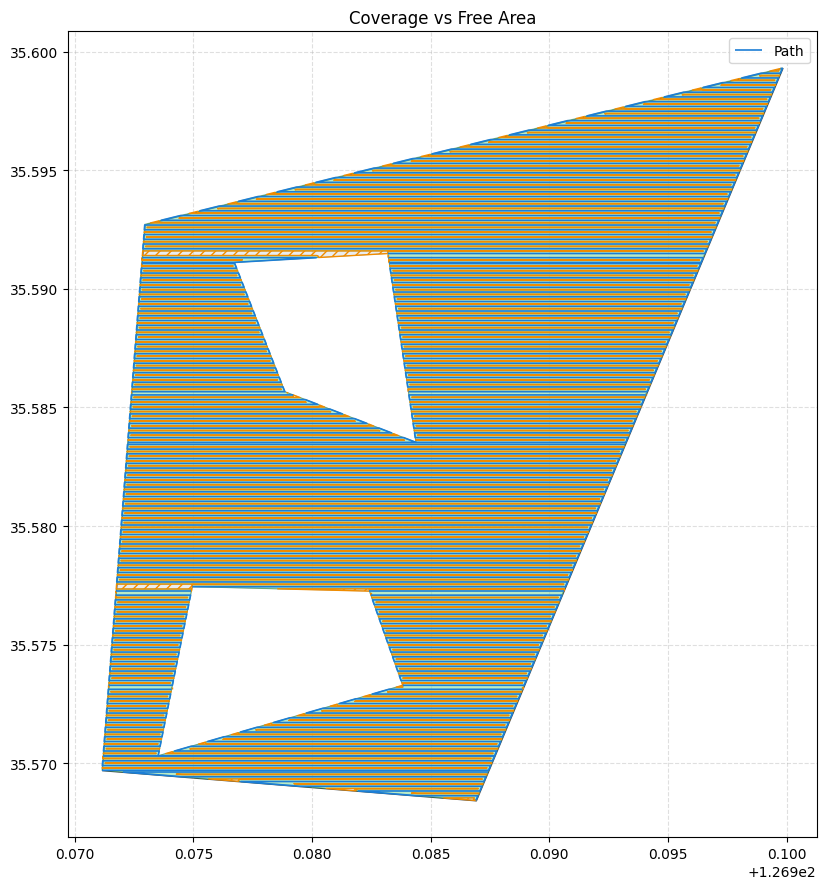

In [57]:
# -*- coding: utf-8 -*-
"""
Run one random set (A + Hs) -> Decompose & Merge -> Path generation (existing lawnmower)
-> Coverage (radius r) computation & visualization.

Requirements:
  - shapely, numpy, pandas, geopandas, matplotlib, pyproj

Usage:
  python run_one_set_with_coverage.py
"""

import json
import math
import random
import collections
import heapq
from dataclasses import dataclass
from typing import List, Tuple, Dict, Set, Any

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString, box, mapping, Point
from shapely.ops import unary_union, transform
from shapely.affinity import rotate
from pyproj import Transformer

# =========================
# (A,H) 랜덤 생성 유틸
# =========================
def _cross(ax, ay, bx, by): return ax*by - ay*bx
def _is_parallel(v1, v2, eps=1e-6): return abs(_cross(v1[0], v1[1], v2[0], v2[1])) < eps

def _edge_vectors(coords):
    v = []
    for i in range(4):
        x1, y1 = coords[i]
        x2, y2 = coords[(i+1) % 4]
        v.append((x2-x1, y2-y1))
    return v

def _is_forbidden_quadrilateral(poly, tol=1e-6):
    # 사다리꼴/평행사변형/직사각형/마름모 배제
    if not poly.is_valid or poly.area < 1e-12: return True
    coords = list(poly.exterior.coords)[:-1]
    if len(coords) != 4: return True
    v = _edge_vectors(coords)
    if _is_parallel(v[0], v[2]) or _is_parallel(v[1], v[3]):  # 대변 평행
        return True
    right_angles = 0
    for i in range(4):
        a, b = v[i], v[(i+1) % 4]
        dot = a[0]*b[0] + a[1]*b[1]
        if abs(dot) < 1e-6: right_angles += 1
    if right_angles >= 2:  # 직사각형 가능성
        return True
    lens = [math.hypot(dx,dy) for dx,dy in v]
    if max(lens) > 0 and (max(lens)-min(lens))/max(lens) < 0.08:  # 마름모 가능성
        return True
    return False

def random_quad_quadrants(x_range=(126.95, 127.0), y_range=(35.55, 35.6), max_tries=400) -> Polygon:
    """
    각 사분면(QI~QIV)에 꼭짓점 하나씩 들어가도록 불규칙 사각형 생성.
    패딩/오프셋을 범위 폭의 비율로 정해, 좁은 범위에서도 안정적으로 동작.
    """
    W = x_range[1] - x_range[0]
    H = y_range[1] - y_range[0]
    if W <= 0 or H <= 0:
        raise ValueError("invalid ranges")

    # 범위 폭 기준 비율(필요에 따라 조절 가능)
    pad_frac   = 0.10   # 경계에서 10%는 비워두고 중심을 고름
    min_frac   = 0.05   # 최소 오프셋 = 폭의 5%
    max_frac   = 0.45   # 최대 오프셋 = 폭의 45% (너무 크게 잡지 않기)

    # 절대값으로 변환
    pad_x = pad_frac * W
    pad_y = pad_frac * H
    min_off_x = min_frac * W
    min_off_y = min_frac * H
    max_off_x = max_frac * W
    max_off_y = max_frac * H

    for _ in range(max_tries):
        # 중심 샘플링 (패딩을 고려)
        cx = random.uniform(x_range[0] + pad_x, x_range[1] - pad_x)
        cy = random.uniform(y_range[0] + pad_y, y_range[1] - pad_y)

        # 각 방향으로 가능한 최대 오프셋(경계 밖으로 나가지 않도록 clamp)
        max_right = min(max_off_x, x_range[1] - cx)
        max_left  = min(max_off_x, cx - x_range[0])
        max_up    = min(max_off_y, y_range[1] - cy)
        max_down  = min(max_off_y, cy - y_range[0])

        # 유효성 체크: 최소 오프셋보다 커야 함
        if min(max_right, max_left, max_up, max_down) <= max(min_off_x, min_off_y):
            continue

        # 사분면별 오프셋 샘플
        dx_r1 = random.uniform(min_off_x, max_right)
        dx_r2 = random.uniform(min_off_x, max_right)
        dx_l1 = random.uniform(min_off_x, max_left)
        dx_l2 = random.uniform(min_off_x, max_left)

        dy_u1 = random.uniform(min_off_y, max_up)
        dy_u2 = random.uniform(min_off_y, max_up)
        dy_d1 = random.uniform(min_off_y, max_down)
        dy_d2 = random.uniform(min_off_y, max_down)

        pts = [
            (cx + dx_r1, cy + dy_u1),  # QI
            (cx - dx_l1, cy + dy_u2),  # QII
            (cx - dx_l2, cy - dy_d1),  # QIII
            (cx + dx_r2, cy - dy_d2),  # QIV
        ]
        # 중심 기준 각도로 CCW 정렬 -> 단순 다각형화
        pts.sort(key=lambda p: math.atan2(p[1] - cy, p[0] - cx))
        poly = Polygon(pts)

        # 금지 형태(사다리꼴/평행사변형/직사각형/마름모) 필터는 기존 함수 사용
        if poly.is_valid and poly.area > 1e-12 and not _is_forbidden_quadrilateral(poly):
            return poly

    raise RuntimeError("사분면 제약 사각형 생성 실패: 시도 횟수 초과")

def random_inner_quad(A: Polygon, scale=0.25, max_tries=400) -> Polygon:
    # A 내부의 불규칙 사각형
    minx, miny, maxx, maxy = A.bounds
    w, h = maxx-minx, maxy-miny
    for _ in range(max_tries):
        cx = random.uniform(minx, maxx)
        cy = random.uniform(miny, maxy)
        if not A.contains(Point(cx,cy)): continue
        offx = random.uniform(0.05*w, scale*w)
        offy = random.uniform(0.05*h, scale*h)
        dx_r1 = random.uniform(0.3*offx, offx)
        dx_r2 = random.uniform(0.3*offx, offx)
        dx_l1 = random.uniform(0.3*offx, offx)
        dx_l2 = random.uniform(0.3*offx, offx)
        dy_u1 = random.uniform(0.3*offy, offy)
        dy_u2 = random.uniform(0.3*offy, offy)
        dy_d1 = random.uniform(0.3*offy, offy)
        dy_d2 = random.uniform(0.3*offy, offy)
        pts = [
            (cx + dx_r1, cy + dy_u1),
            (cx - dx_l1, cy + dy_u2),
            (cx - dx_l2, cy - dy_d1),
            (cx + dx_r2, cy - dy_d2),
        ]
        pts.sort(key=lambda p: math.atan2(p[1]-cy, p[0]-cx))
        poly = Polygon(pts)
        if poly.is_valid and A.contains(poly) and not _is_forbidden_quadrilateral(poly):
            return poly
    raise RuntimeError("내부 사각형 생성 실패")

def generate_one_set(holes_per_A: int = 2):
    A = random_quad_quadrants()
    holes: List[Polygon] = []
    for _ in range(holes_per_A):
        for _try in range(600):
            h = random_inner_quad(A)
            if all(not h.intersects(h2) for h2 in holes):
                holes.append(h); break
        else:
            raise RuntimeError("겹치지 않는 H 생성 실패")
    return A, holes

# =========================
# Geometry helpers (원래 코드 유지)
# =========================
def polygon_internal_angles(poly: Polygon):
    coords = list(poly.exterior.coords)[:-1]; n = len(coords)
    def angle(a, b, c):
        ax, ay = a; bx, by = b; cx, cy = c
        v1 = np.array([ax - bx, ay - by]); v2 = np.array([cx - bx, cy - by])
        n1 = np.linalg.norm(v1) + 1e-12; n2 = np.linalg.norm(v2) + 1e-12
        v1 = v1 / n1; v2 = v2 / n2
        dot = np.clip(np.dot(v1, v2), -1.0, 1.0); ang = math.degrees(math.acos(dot))
        cross = v1[0] * v2[1] - v1[1] * v2[0]
        if cross < 0: ang = 360 - ang
        return ang
    return [angle(coords[(i - 1) % n], coords[i], coords[(i + 1) % n]) for i in range(n)]

def Convex(poly: Polygon, angle_tol: float = 1e-6) -> bool:
    if poly.is_empty or (not poly.is_valid) or len(poly.interiors) > 0: return False
    for ang in polygon_internal_angles(poly):
        if ang > 180 + angle_tol: return False
    return True

def all_vertex_y_levels(geom) -> List[float]:
    ys = []; geoms = getattr(geom, 'geoms', [geom])
    for g in geoms:
        if isinstance(g, Polygon):
            ys.extend(np.array(g.exterior.coords)[:, 1])
            for ring in g.interiors: ys.extend(np.array(ring.coords)[:, 1])
    return sorted(list(set(ys)))

def PartitionHorizontal(A: Polygon, H: List[Polygon]) -> List[Polygon]:
    free = A.difference(unary_union(H)) if H else A
    if free.is_empty: return []
    ys = all_vertex_y_levels(free); minx, _, maxx, _ = free.bounds
    parts: List[Polygon] = []
    for i in range(len(ys) - 1):
        y0, y1 = ys[i], ys[i + 1]
        if y1 <= y0 + 1e-9: continue
        slab = box(minx - 1.0, y0, maxx + 1.0, y1); inter = free.intersection(slab)
        if not inter.is_empty:
            if isinstance(inter, Polygon): parts.append(inter)
            else:
                geoms_list = [g for g in getattr(inter, "geoms", []) if isinstance(g, Polygon)]
                sorted_geoms = sorted(geoms_list, key=lambda p: p.bounds[0])
                parts.extend(sorted_geoms)
    return parts

def BuildAdjacency(parts: List[Polygon], min_shared: float) -> Dict[int, Set[int]]:
    N = len(parts); adj: Dict[int, Set[int]] = {i: set() for i in range(N)}
    for i in range(N):
        for j in range(i + 1, N):
            inter = parts[i].boundary.intersection(parts[j].boundary)
            if not inter.is_empty and inter.length > min_shared:
                adj[i].add(j); adj[j].add(i)
    return adj

def DFS_Order_With_Levels(adj: Dict[int, Set[int]], root: int, N: int) -> Tuple[List[int], List[int]]:
    if N == 0: return [], []
    levels = [-1] * N
    if root < N:
        levels[root] = 0; queue = collections.deque([root]); visited_for_level = {root}
        while queue:
            u = queue.popleft()
            for v in sorted(list(adj.get(u, set()))):
                if v not in visited_for_level:
                    visited_for_level.add(v); levels[v] = levels[u] + 1; queue.append(v)
    order: List[int] = []; visited_for_dfs = [False] * N
    if root < N:
        stack = [root]; visited_for_dfs[root] = True
        while stack:
            u = stack.pop(); order.append(u)
            for v in sorted(list(adj.get(u, set())), reverse=True):
                if not visited_for_dfs[v] and levels[v] > levels[u]:
                    visited_for_dfs[v] = True; stack.append(v)
    return order, levels

@dataclass
class Segment:
    valid: bool; node_range: Tuple[int, int]; nodes: List[int]; edges: List[Tuple[int, int]]

def GenerateSegmentsFromPath(order: List[int], adj: Dict[int, Set[int]], levels: List[int]) -> List[Segment]:
    if not order: return []
    all_segments_nodes: List[List[int]] = []
    current_segment_nodes = [order[0]]
    for i in range(len(order) - 1):
        u, v = order[i], order[i+1]
        is_continuous_branch = (v in adj.get(u, set())) and (levels[v] > levels[u])
        if is_continuous_branch: current_segment_nodes.append(v)
        else: all_segments_nodes.append(current_segment_nodes); current_segment_nodes = [v]
    all_segments_nodes.append(current_segment_nodes)
    final_segments: List[Segment] = []
    for nodes in all_segments_nodes:
        if not nodes: continue
        node_range = (nodes[0], nodes[-1]); edges = []
        for i in range(len(nodes) - 1):
            u, v = nodes[i], nodes[i+1]
            if v in adj.get(u, set()): edges.append((u,v))
        final_segments.append(Segment(True, node_range, nodes, edges))
    return final_segments

def MergeSegment(parts: List[Polygon], seg_nodes: List[int], seg_edges: List[Tuple[int, int]], angle_tol: float) -> List[Polygon]:
    if not seg_nodes: return []
    poly_map: Dict[int, Polygon] = {nid: parts[nid] for nid in seg_nodes}
    adj: Dict[int, Set[int]] = {nid: set() for nid in seg_nodes}
    for (u, v) in seg_edges:
        if u in adj and v in adj: adj[u].add(v); adj[v].add(u)
    changed = True
    while changed and len(poly_map) > 1:
        changed = False
        current_nodes = [n for n in seg_nodes if n in poly_map]
        for i in range(len(current_nodes) - 1):
            u, v = current_nodes[i], current_nodes[i+1]
            if v not in adj.get(u, set()): continue
            pu, pv = poly_map[u], poly_map[v]
            U = unary_union([pu, pv])
            if isinstance(U, Polygon) and Convex(U, angle_tol):
                poly_map[u] = U; del poly_map[v]
                v_neighbors = list(adj.pop(v, set()))
                for w in v_neighbors:
                    if w in adj:
                        adj[w].discard(v)
                        if w != u: adj[w].add(u); adj[u].add(w)
                changed = True
                break
    return list(poly_map.values())

# ------------------------- Path Generation (기존 유지) -------------------------
def lawnmower(poly_xy: Polygon, spacing_m: float) -> list[tuple[float,float]]:
    """poly_xy: (네가 쓰던 좌표계 그대로) 폴리곤, 반환: [(x,y), ...]"""
    minx, miny, maxx, maxy = poly_xy.bounds
    y = miny
    flip = False
    path_xy = []
    while y <= maxy + 1e-12:
        seg = LineString([(minx, y), (maxx, y)]).intersection(poly_xy)
        if not seg.is_empty:
            if hasattr(seg, "geoms"):
                seg = max(seg.geoms, key=lambda s: s.length)
            coords = list(seg.coords)
            if flip: coords.reverse()
            path_xy.extend(coords)
        y += spacing_m
        flip = not flip
    return path_xy

def build_transition_graph(parts: List[Polygon], adj: Dict[int, Set[int]]):
    node_coords = {}; graph = collections.defaultdict(list); edge_midpoints = {}
    node_id_counter = 0
    for p1_idx, neighbors in adj.items():
        for p2_idx in neighbors:
            if p1_idx >= p2_idx: continue
            edge = tuple(sorted((p1_idx, p2_idx)))
            if edge not in edge_midpoints:
                shared_geom = parts[p1_idx].boundary.intersection(parts[p2_idx].boundary)
                if not shared_geom.is_empty:
                    midpoint = shared_geom.centroid
                    node_coords[node_id_counter] = (midpoint.x, midpoint.y)
                    edge_midpoints[edge] = node_id_counter
                    node_id_counter += 1
    for part_idx, part_poly in enumerate(parts):
        part_doorways = []
        for neighbor_idx in adj.get(part_idx, set()):
            edge = tuple(sorted((part_idx, neighbor_idx)))
            if edge in edge_midpoints: part_doorways.append(edge_midpoints[edge])
        for i in range(len(part_doorways)):
            for j in range(i + 1, len(part_doorways)):
                u, v = part_doorways[i], part_doorways[j]
                p1 = Point(node_coords[u]); p2 = Point(node_coords[v])
                dist = p1.distance(p2)
                graph[u].append((v, dist)); graph[v].append((u, dist))
    return graph, node_coords, edge_midpoints

def dijkstra_path(graph, node_coords, start_node, end_node):
    pq = [(0, start_node, [])]; visited = set()
    while pq:
        dist, current_node, path = heapq.heappop(pq)
        if current_node in visited: continue
        visited.add(current_node)
        path = path + [current_node]
        if current_node == end_node: return [node_coords[n] for n in path]
        for neighbor, weight in graph.get(current_node, []):
            if neighbor not in visited:
                heapq.heappush(pq, (dist + weight, neighbor, path))
    return []

def connect_paths_robust(paths: List[LineString], parts: List[Polygon], adj: Dict[int, Set[int]], nav_graph_data) -> LineString:
    if len(paths) <= 1: return paths[0] if paths else LineString()
    graph, node_coords, edge_midpoints = nav_graph_data
    node_id_counter = len(node_coords)
    full_path_coords = []
    current_path = paths[0]
    full_path_coords.extend(list(current_path.coords))
    for i in range(1, len(paths)):
        last_point = Point(full_path_coords[-1])
        next_path = paths[i]
        start_next_point = Point(next_path.coords[0])
        start_part_idx = next((j for j, p in enumerate(parts) if p.buffer(1e-9).contains(last_point)), -1)
        end_part_idx = next((j for j, p in enumerate(parts) if p.buffer(1e-9).contains(start_next_point)), -1)
        if start_part_idx != -1 and end_part_idx != -1 and start_part_idx != end_part_idx:
            temp_graph = {k: v[:] for k, v in graph.items()}; temp_node_coords = node_coords.copy()
            start_node_id, end_node_id = node_id_counter, node_id_counter + 1
            temp_node_coords[start_node_id] = (last_point.x, last_point.y)
            temp_node_coords[end_node_id] = (start_next_point.x, start_next_point.y)
            for neighbor_idx in adj.get(start_part_idx, set()):
                edge = tuple(sorted((start_part_idx, neighbor_idx)))
                if edge in edge_midpoints:
                    doorway_id = edge_midpoints[edge]
                    dist = last_point.distance(Point(temp_node_coords[doorway_id]))
                    temp_graph.setdefault(start_node_id, []).append((doorway_id, dist))
                    temp_graph.setdefault(doorway_id, []).append((start_node_id, dist))
            for neighbor_idx in adj.get(end_part_idx, set()):
                edge = tuple(sorted((end_part_idx, neighbor_idx)))
                if edge in edge_midpoints:
                    doorway_id = edge_midpoints[edge]
                    dist = start_next_point.distance(Point(temp_node_coords[doorway_id]))
                    temp_graph.setdefault(end_node_id, []).append((doorway_id, dist))
                    temp_graph.setdefault(doorway_id, []).append((end_node_id, dist))
            transition_coords = dijkstra_path(temp_graph, temp_node_coords, start_node_id, end_node_id)
            if transition_coords: full_path_coords.extend(transition_coords[1:-1])
        full_path_coords.extend(list(next_path.coords))
    return LineString(full_path_coords)

# ------------------------- Visualization helpers (선택적으로 사용) -------------------------
def visualize_partition(parts: List[Polygon]):
    fig, ax = plt.subplots(figsize=(10, 8))
    gpd.GeoSeries(parts).plot(ax=ax, color='#dfe7fd', edgecolor='#3a0ca3', linewidth=0.8)
    for i, p in enumerate(parts):
        rp = p.representative_point()
        ax.text(rp.x, rp.y, f"{i}", ha='center', va='center', fontsize=8, color='#1b263b')
    ax.set_title("Partitioned Convex Parts", fontsize=16, fontweight='bold')
    ax.set_aspect('equal', adjustable='box'); ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()

def visualize_dfs_segments(parts: List[Polygon], segments: List['Segment'], order: List[int], levels: List[int]):
    fig, ax = plt.subplots(figsize=(10, 8))
    base = gpd.GeoSeries(parts)
    base.plot(ax=ax, color='#f1f1f1', edgecolor='#cccccc', linewidth=0.6, zorder=1)
    cmap = plt.cm.get_cmap('tab10', max(1, len(segments)))
    for i, seg in enumerate(segments):
        if not seg.valid: continue
        seg_polys = [parts[nid] for nid in seg.nodes if nid < len(parts)]
        if not seg_polys: continue
        gpd.GeoSeries(seg_polys).plot(ax=ax, color=cmap(i), alpha=0.5, edgecolor='white', linewidth=0.6, label=f"Segment {i+1}", zorder=2)
    reps = {i: p.representative_point() for i, p in enumerate(parts)}
    for i, p in enumerate(parts):
        rp = reps[i]; lvl = levels[i]
        ax.text(rp.x, rp.y, f"{i}\nL{lvl if lvl!=-1 else 'NA'}", fontsize=7, ha='center', va='center', color='#333', zorder=3)
    for i in range(len(order) - 1):
        u, v = order[i], order[i+1]
        if u in reps and v in reps:
            a = reps[u]; b = reps[v]
            ax.annotate("", xy=(b.x, b.y), xytext=(a.x, a.y),
                        arrowprops=dict(arrowstyle="->", lw=1.0, color='#d00000', shrinkA=5, shrinkB=5), zorder=4)
    ax.legend(loc='upper right'); ax.set_title("DFS-Based Segment Grouping & Order", fontsize=16, fontweight='bold')
    ax.set_aspect('equal', adjustable='box'); ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()

def visualize_paths(parts: List[Polygon], per_region_paths: List[List[LineString]], final_path: LineString):
    fig, ax = plt.subplots(figsize=(12, 9))
    gpd.GeoSeries(parts).plot(ax=ax, color='#f8f9fa', edgecolor='#adb5bd', linewidth=0.6, zorder=1)
    for ridx, path_list in enumerate(per_region_paths):
        for p in path_list:
            gpd.GeoSeries([p]).plot(ax=ax, linewidth=1.0, zorder=3)
    if final_path and not final_path.is_empty:
        gpd.GeoSeries([final_path]).plot(ax=ax, linewidth=2.0, zorder=4)
    ax.set_title("Path Generation: Region Paths & Final Connected Trajectory", fontsize=16, fontweight='bold')
    ax.set_aspect('equal', adjustable='box'); ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()

def visualize_results_combined(result: Dict[str, Any], final_path: LineString):
    parts = result["parts"]; segments = result["segments"]; order = result["order"]; levels = result["levels"]
    fig, ax = plt.subplots(figsize=(14, 11))
    gpd.GeoSeries(parts).plot(ax=ax, color='#e0e0e0', edgecolor='white', linewidth=0.7, zorder=1)
    colors = plt.cm.get_cmap('tab10', len(segments))
    for i, seg in enumerate(segments):
        if not seg.valid: continue
        seg_polys = [parts[node_id] for node_id in seg.nodes if node_id < len(parts)]
        if not seg_polys: continue
        seg_union = unary_union(seg_polys)
        gpd.GeoSeries([seg_union]).plot(ax=ax, color=colors(i), edgecolor='white', alpha=0.5, zorder=2, label=f"Segment {i+1}")
    for i, p in enumerate(parts):
        point = p.representative_point(); level = levels[i]
        label = f"{i}\n(L{level})" if level != -1 else f"{i}\n(N/A)"
        ax.text(point.x, point.y, label, fontsize=6, ha='center', va='center', color='#333', zorder=4)
    points = {i: p.representative_point() for i, p in enumerate(parts)}
    for i in range(len(order) - 1):
        u, v = order[i], order[i+1]
        if u in points and v in points:
            p_start = points[u]; p_end = points[v]
            ax.annotate("", xy=(p_end.x, p_end.y), xytext=(p_start.x, p_start.y),
                        arrowprops=dict(arrowstyle="->", color="red", lw=1.0, shrinkA=5, shrinkB=5), zorder=3)
    if final_path and not final_path.is_empty:
        gpd.GeoSeries([final_path]).plot(ax=ax, linewidth=1.5, zorder=5, label="Final UAV Path")
    ax.set_title("Complete UAV Path Plan Visualization (Combined)", fontsize=18, fontweight='bold')
    ax.set_xlabel("X Coordinate"); ax.set_ylabel("Y Coordinate")
    ax.set_aspect('equal', adjustable='box'); ax.legend(title="Layers")
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()

def reorder_paths_nearest_neighbor(paths: List[LineString]) -> List[LineString]:
    if len(paths) <= 1: return paths
    unvisited_paths = list(paths); ordered_paths = []
    current_path = unvisited_paths.pop(0); ordered_paths.append(current_path)
    while unvisited_paths:
        last_point = Point(current_path.coords[-1]); best_dist = float('inf'); best_idx = -1; best_path_reversed = False
        for i, p in enumerate(unvisited_paths):
            start_p = Point(p.coords[0]); end_p = Point(p.coords[-1])
            dist_to_start = last_point.distance(start_p); dist_to_end = last_point.distance(end_p)
            if dist_to_start < best_dist: best_dist = dist_to_start; best_idx = i; best_path_reversed = False
            if dist_to_end < best_dist: best_dist = dist_to_end; best_idx = i; best_path_reversed = True
        next_path = unvisited_paths.pop(best_idx)
        if best_path_reversed: coords = list(next_path.coords); coords.reverse(); next_path = LineString(coords)
        ordered_paths.append(next_path); current_path = next_path
    return ordered_paths

# ------------------------- Main algorithm (유지) -------------------------
def DecomposeAndMerge(A: Polygon, H: List[Polygon], min_shared: float, angle_tol: float, root: int = 0) -> Dict[str, Any]:
    parts = PartitionHorizontal(A, H)
    adj = BuildAdjacency(parts, min_shared)
    order, levels = DFS_Order_With_Levels(adj, root, len(parts))
    segments = GenerateSegmentsFromPath(order, adj, levels)
    merged_segments: List[List[Polygon]] = []
    for seg in segments:
        if seg.valid: Ms = MergeSegment(parts, seg.nodes[:], seg.edges[:], angle_tol)
        else: Ms = []
        merged_segments.append(Ms)
    return { "parts": parts, "adj": adj, "order": order, "levels": levels,
             "segments": segments, "merged_segments": merged_segments }

# =========================
# UTM 변환 & 커버리지
# =========================
def _utm_epsg_for_lonlat(lon: float, lat: float) -> int:
    zone = int((lon + 180) / 6) + 1
    return 32600 + zone  # WGS84 UTM 북반구

def _to_local_m_by_ref(ref_geom, geom):
    c = ref_geom.centroid
    epsg = _utm_epsg_for_lonlat(c.x, c.y)
    tr = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg}", always_xy=True)
    return transform(lambda x, y, z=None: tr.transform(x, y), geom)

def _to_wgs84_by_ref(ref_geom, geom_local):
    c = ref_geom.centroid
    epsg = _utm_epsg_for_lonlat(c.x, c.y)
    tr = Transformer.from_crs(f"EPSG:{epsg}", "EPSG:4326", always_xy=True)
    return transform(lambda x, y, z=None: tr.transform(x, y), geom_local)

def compute_coverage_with_paths(A: Polygon, H: list[Polygon], paths: list, radius_m: float):
    # 자유영역 (WGS84)
    free_wgs = A.difference(unary_union(H)) if H else A
    if free_wgs.is_empty:
        return {
            "free_area_m2": 0.0,
            "covered_m2": 0.0,
            "coverage_ratio": 0.0,
            "overlap_m2": 0.0,
            "overlap_ratio_over_free": 0.0,
            "overlap_ratio_over_covered": 0.0,
            "covered_geom_wgs84": Polygon(),
            "uncovered_geom_wgs84": A
        }

    # 자유영역을 지역좌표(미터)로
    free_loc = _to_local_m_by_ref(free_wgs, free_wgs)

    if not paths:
        # 경로 없으면 커버/중복 0
        covered_loc = free_loc.buffer(0)
        overlap_m2 = 0.0
    else:
        # 각 경로 buffer → 자유영역과 교차 → 합산면적
        buffers_loc = []
        sum_single_cover_m2 = 0.0
        for p in paths:
            p_loc = _to_local_m_by_ref(free_wgs, p)
            b_loc = p_loc.buffer(radius_m, cap_style=2)  # (기존 스타일 유지)
            buffers_loc.append(b_loc)
            sum_single_cover_m2 += float(free_loc.intersection(b_loc).area)

        # 합집합 커버
        union_buf_loc = unary_union(buffers_loc)
        covered_loc = free_loc.intersection(union_buf_loc)

        # 중복 = (합산면적) - (합집합면적)
        overlap_m2 = max(0.0, sum_single_cover_m2 - float(covered_loc.area))

    free_area_m2 = float(free_loc.area)
    covered_m2 = float(covered_loc.area) if not covered_loc.is_empty else 0.0
    coverage_ratio = (covered_m2 / free_area_m2) if free_area_m2 > 0 else 0.0

    # 중복 비율 (두 가지)
    overlap_ratio_over_free = (overlap_m2 / free_area_m2) if free_area_m2 > 0 else 0.0
    overlap_ratio_over_covered = (overlap_m2 / covered_m2) if covered_m2 > 0 else 0.0

    # 시각화용 WGS84로 되돌리기
    covered_wgs = _to_wgs84_by_ref(free_wgs, covered_loc) if not covered_loc.is_empty else Polygon()
    uncovered_loc = free_loc.difference(covered_loc) if covered_m2 > 0 else free_loc
    uncovered_wgs = _to_wgs84_by_ref(free_wgs, uncovered_loc) if not uncovered_loc.is_empty else Polygon()

    print(
        f"🧮 Coverage (r={radius_m:.1f} m)\n"
        f"  - Free Area     : {free_area_m2:,.0f} m²\n"
        f"  - Covered (≥1x) : {covered_m2:,.0f} m² ({coverage_ratio*100:,.2f}%)\n"
        f"  - Overlap (≥2x) : {overlap_m2:,.0f} m² "
        f"(over free {overlap_ratio_over_free*100:,.2f}%, over covered {overlap_ratio_over_covered*100:,.2f}%)"
    )

    return {
        "free_area_m2": free_area_m2,
        "covered_m2": covered_m2,
        "coverage_ratio": coverage_ratio,
        "overlap_m2": overlap_m2,
        "overlap_ratio_over_free": overlap_ratio_over_free,
        "overlap_ratio_over_covered": overlap_ratio_over_covered,
        "covered_geom_wgs84": covered_wgs,
        "uncovered_geom_wgs84": uncovered_wgs,
    }

def plot_coverage(A: Polygon, H: list[Polygon], covered_wgs, uncovered_wgs, paths):
    fig, ax = plt.subplots(figsize=(10, 9))
    gpd.GeoSeries([A]).plot(ax=ax, color="#e9ecef", edgecolor="#495057", linewidth=0.8, zorder=1)
    if H:
        gpd.GeoSeries(H).plot(ax=ax, color="white", edgecolor="#adb5bd", linewidth=0.6, zorder=2)
    if covered_wgs and not covered_wgs.is_empty:
        gpd.GeoSeries([covered_wgs]).plot(ax=ax, color="#8ce99a", alpha=0.5,
                                          edgecolor="#2b8a3e", linewidth=0.8, zorder=3, label="Covered")
    if uncovered_wgs and not uncovered_wgs.is_empty:
        gpd.GeoSeries([uncovered_wgs]).plot(ax=ax, facecolor="none", edgecolor="#f08c00",
                                            linewidth=1.0, hatch="///", zorder=4, label="Uncovered")
    if paths:
        gpd.GeoSeries(paths).plot(ax=ax, color="#1c7ed6", linewidth=1.2, zorder=5, label="Path")
    ax.set_aspect("equal", adjustable="box"); ax.grid(True, linestyle="--", alpha=0.4)
    ax.set_title("Coverage vs Free Area"); ax.legend()
    plt.tight_layout(); plt.show()

# =========================
# Main: 한 세트 생성 → 경로 생성 → 커버리지
# =========================
def main():
    random.seed()

    # 1) A, H(겹치지 않게) 한 세트 생성
    A, H = generate_one_set(holes_per_A=2)

    # 2) Decompose & Merge
    print("\n🚀 Running DecomposeAndMerge...")
    result = DecomposeAndMerge(A, H, min_shared=0.0, angle_tol=1e-6, root=0)
    parts = result["parts"]; adj = result["adj"]
    order = result["order"]; levels = result["levels"]; segments = result["segments"]
    print(f"...parts={len(parts)}, segments={len([s for s in segments if s.valid])}")

    # 3) NAV graph
    nav_graph_data = build_transition_graph(parts, adj)

    # 4) Stage 1: Generate paths per merged region (using existing lawnmower)
    print("🌿 Stage 1: Generating paths per merged region...")
    path_spacing = 0.00020  # 네가 쓰던 단위를 유지 (경위도 간격). 필요시 조정
    per_region_paths: List[List[LineString]] = []
    all_segment_super_paths: List[LineString] = []

    for seg in segments:
        if not seg.valid or not seg.nodes: continue
        # 해당 세그먼트의 머지 결과 찾기
        merged_polys_for_this_segment = []
        first_node_in_seg = seg.nodes[0]
        for merged_poly_list in result['merged_segments']:
            if merged_poly_list:
                U = unary_union(merged_poly_list).buffer(1e-9)
                if U.contains(parts[first_node_in_seg]):
                    merged_polys_for_this_segment.extend(merged_poly_list)
                    break
        if not merged_polys_for_this_segment: continue

        # 각 머지폴리곤에 lawnmower 적용
        individual_paths_in_segment = []
        for poly in merged_polys_for_this_segment:
            coords = lawnmower(poly, spacing_m=path_spacing)
            if len(coords) > 1:
                individual_paths_in_segment.append(LineString(coords))
        if not individual_paths_in_segment: continue

        per_region_paths.append(individual_paths_in_segment[:])

        # 세그먼트 내부 연결
        ordered_paths_in_segment = reorder_paths_nearest_neighbor(individual_paths_in_segment)
        segment_super_path = connect_paths_robust(ordered_paths_in_segment, parts, adj, nav_graph_data)
        if segment_super_path.length > 0:
            all_segment_super_paths.append(segment_super_path)

    print(f"...Created {len(all_segment_super_paths)} continuous segment paths.")

    # 5) Stage 2: 모든 세그먼트 경로를 최종 연결
    print("🔗 Stage 2: Connecting all segment paths into a final trajectory...")
    final_path = connect_paths_robust(all_segment_super_paths, parts, adj, nav_graph_data)
    print("...Final path created.")

    # ----- (선택) 분리 시각화 -----
    # visualize_partition(parts)
    # visualize_dfs_segments(parts, segments, order, levels)
    # visualize_paths(parts, per_region_paths, final_path)

    # 6) Coverage 계산 & 시각화
    # (a) 최종 연결 경로만으로 커버 계산
    paths_for_coverage = [p for group in per_region_paths for p in group]


    # (b) 내부 라운모워 라인까지 모두 포함하려면 아래로 교체
    # paths_for_coverage = [p for group in per_region_paths for p in group] + all_segment_super_paths

    sensor_radius_m = 10.0  # 센서 커버 반경(미터)
    cov = compute_coverage_with_paths(A, H, paths_for_coverage, radius_m=sensor_radius_m)
    print(f"Coverage ratio (>=1x): {cov['coverage_ratio']*100:.2f}%")
    print(f"Overlap ratio (>=2x) over free    : {cov['overlap_ratio_over_free']*100:.2f}%")
    print(f"Overlap ratio (>=2x) over covered : {cov['overlap_ratio_over_covered']*100:.2f}%")
    # 시각화
    plot_coverage(A, H, cov["covered_geom_wgs84"], cov["uncovered_geom_wgs84"], paths_for_coverage)

if __name__ == "__main__":
    main()

In [64]:
# ===== 반복용: 한 번의 시뮬레이션 실행 =====
def run_single_trial(path_spacing=0.00020, sensor_radius_m=20.0, holes_per_A=2):
    """
    반환:
      coverage_ratio             : 덮인 영역(≥1x) / 자유영역
      overlap_ratio_over_free    : 중복(≥2x) / 자유영역
      overlap_ratio_over_covered : 중복(≥2x) / 덮인영역(≥1x)
    """
    # 1) A, H 생성
    A, H = generate_one_set(holes_per_A=holes_per_A)

    # 2) Decompose & Merge
    result = DecomposeAndMerge(A, H, min_shared=0.0, angle_tol=1e-6, root=0)
    parts = result["parts"]; adj = result["adj"]; segments = result["segments"]

    # 3) NAV graph
    nav_graph_data = build_transition_graph(parts, adj)

    # 4) per-merged-region 경로 생성
    per_region_paths: List[List[LineString]] = []
    all_segment_super_paths: List[LineString] = []

    for seg in segments:
        if not seg.valid or not seg.nodes:
            continue
        merged_polys_for_this_segment = []
        first_node_in_seg = seg.nodes[0]
        for merged_poly_list in result['merged_segments']:
            if merged_poly_list:
                U = unary_union(merged_poly_list).buffer(1e-9)
                if U.contains(parts[first_node_in_seg]):
                    merged_polys_for_this_segment.extend(merged_poly_list)
                    break
        if not merged_polys_for_this_segment:
            continue

        # lawnmower로 "개별 스트립" 생성
        indiv_paths = []
        for poly in merged_polys_for_this_segment:
            coords = lawnmower(poly, spacing_m=path_spacing)
            if len(coords) > 1:
                indiv_paths.append(LineString(coords))
        if not indiv_paths:
            continue

        per_region_paths.append(indiv_paths[:])

        # 세그먼트 내부 연결(참고용)
        ordered = reorder_paths_nearest_neighbor(indiv_paths)
        seg_super = connect_paths_robust(ordered, parts, adj, nav_graph_data)
        if seg_super.length > 0:
            all_segment_super_paths.append(seg_super)

    # 최종 연결 경로는 시각화/이동 경로용, 커버 계산은 "개별 스트립"으로
    paths_for_coverage = [p for group in per_region_paths for p in group]

    cov = compute_coverage_with_paths(A, H, paths_for_coverage, radius_m=sensor_radius_m)
    return float(cov["coverage_ratio"]), float(cov["overlap_ratio_over_free"]), float(cov["overlap_ratio_over_covered"])


# ===== 반복 실행: 평균/표준편차 출력 =====
def run_many(n_runs=100, path_spacing=0.00020, sensor_radius_m=20.0, holes_per_A=2, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    covs, ovs_free, ovs_cov = [], [], []

    for i in range(n_runs):
        try:
            c, of, oc = run_single_trial(
                path_spacing=path_spacing,
                sensor_radius_m=sensor_radius_m,
                holes_per_A=holes_per_A
            )
            covs.append(c); ovs_free.append(of); ovs_cov.append(oc)
        except Exception as e:
            # 실패 run은 스킵
            # print(f"[WARN] run {i+1} skipped: {e}")
            continue

    covs = np.array(covs, dtype=float)
    ovs_free = np.array(ovs_free, dtype=float)
    ovs_cov = np.array(ovs_cov, dtype=float)

    # 표본 표준편차(ddof=1)
    def mean_std(a):
        if len(a) == 0: return float("nan"), float("nan")
        if len(a) == 1: return float(a[0]), float("nan")
        return float(np.mean(a)), float(np.std(a, ddof=1))

    cov_mean, cov_std = mean_std(covs)
    ovf_mean, ovf_std = mean_std(ovs_free)
    ovc_mean, ovc_std = mean_std(ovs_cov)

    print(f"\n==== Results over {len(covs)}/{n_runs} runs ====")
    print(f"  path_spacing (deg)  : {path_spacing}")
    print(f"  sensor_radius_m     : {sensor_radius_m}")
    print(f"  holes_per_A         : {holes_per_A}")
    print(f"1) Coverage (>=1x)    : mean {cov_mean*100:.2f}% | std {cov_std*100:.2f}%")
    print(f"2) Overlap (>=2x) / Free    : mean {ovf_mean*100:.2f}% | std {ovf_std*100:.2f}%")
    print(f"   Overlap (>=2x) / Covered : mean {ovc_mean*100:.2f}% | std {ovc_std*100:.2f}%")

    return (covs, cov_mean, cov_std), (ovs_free, ovf_mean, ovf_std), (ovs_cov, ovc_mean, ovc_std)


# ===== 메인: 100회 반복 실행 =====
if __name__ == "__main__":
    N = 100
    PATH_SPACING = 0.00018   # 약 22m @ 위도 35.6° 근처 (경도 기준)
    SENSOR_RADIUS_M = 10.0
    HOLES = 5
    SEED = None

    run_many(
        n_runs=N,
        path_spacing=PATH_SPACING,
        sensor_radius_m=SENSOR_RADIUS_M,
        holes_per_A=HOLES,
        seed=SEED
    )

🧮 Coverage (r=10.0 m)
  - Free Area     : 1,712,096 m²
  - Covered (≥1x) : 1,704,633 m² (99.56%)
  - Overlap (≥2x) : 154,350 m² (over free 9.02%, over covered 9.05%)
🧮 Coverage (r=10.0 m)
  - Free Area     : 4,430,110 m²
  - Covered (≥1x) : 4,414,592 m² (99.65%)
  - Overlap (≥2x) : 295,412 m² (over free 6.67%, over covered 6.69%)
🧮 Coverage (r=10.0 m)
  - Free Area     : 2,989,343 m²
  - Covered (≥1x) : 2,979,690 m² (99.68%)
  - Overlap (≥2x) : 209,942 m² (over free 7.02%, over covered 7.05%)
🧮 Coverage (r=10.0 m)
  - Free Area     : 2,625,596 m²
  - Covered (≥1x) : 2,621,132 m² (99.83%)
  - Overlap (≥2x) : 121,410 m² (over free 4.62%, over covered 4.63%)
🧮 Coverage (r=10.0 m)
  - Free Area     : 2,757,766 m²
  - Covered (≥1x) : 2,741,969 m² (99.43%)
  - Overlap (≥2x) : 229,828 m² (over free 8.33%, over covered 8.38%)
🧮 Coverage (r=10.0 m)
  - Free Area     : 3,001,475 m²
  - Covered (≥1x) : 2,989,262 m² (99.59%)
  - Overlap (≥2x) : 193,121 m² (over free 6.43%, over covered 6.46%)
🧮 Co

In [ ]:
import random
import math
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

# ---------- 유틸 ----------
def _cross(ax, ay, bx, by):
    return ax*by - ay*bx

def _is_parallel(v1, v2, eps=1e-6):
    return abs(_cross(v1[0], v1[1], v2[0], v2[1])) < eps

def _edge_vectors(coords):
    v = []
    for i in range(4):
        x1, y1 = coords[i]
        x2, y2 = coords[(i+1) % 4]
        v.append((x2-x1, y2-y1))
    return v

def _is_forbidden_quadrilateral(poly, tol=1e-6):
    if not poly.is_valid or poly.area < 1e-8:
        return True
    coords = list(poly.exterior.coords)[:-1]
    if len(coords) != 4:
        return True

    v = _edge_vectors(coords)
    # 대변 평행 → 사다리꼴/평행사변형
    if _is_parallel(v[0], v[2]) or _is_parallel(v[1], v[3]):
        return True
    # 직각 2개 이상 → 직사각형
    right_angles = 0
    for i in range(4):
        a = v[i]; b = v[(i+1) % 4]
        dot = a[0]*b[0] + a[1]*b[1]
        if abs(dot) < 1e-6:
            right_angles += 1
    if right_angles >= 2:
        return True
    # 변 길이 모두 비슷 → 마름모
    lens = [math.hypot(dx, dy) for dx, dy in v]
    if max(lens) > 0 and (max(lens) - min(lens)) / max(lens) < 0.08:
        return True
    return False

# ---------- A: 사분면 제약 사각형 ----------
def random_quad_quadrants(x_range=(126.0, 128.0), y_range=(35.0, 48.0), max_tries=200):
    for _ in range(max_tries):
        cx = random.uniform(x_range[0] + 0.2, x_range[1] - 0.2)
        cy = random.uniform(y_range[0] + 0.2, y_range[1] - 0.2)

        max_right = min(0.8, x_range[1] - cx)
        max_left  = min(0.8, cx - x_range[0])
        max_up    = min(0.8, y_range[1] - cy)
        max_down  = min(0.8, cy - y_range[0])
        min_off = 0.05

        if min(max_right, max_left, max_up, max_down) <= min_off:
            continue

        dx_r1 = random.uniform(min_off, max_right)
        dx_r2 = random.uniform(min_off, max_right)
        dx_l1 = random.uniform(min_off, max_left)
        dx_l2 = random.uniform(min_off, max_left)
        dy_u1 = random.uniform(min_off, max_up)
        dy_u2 = random.uniform(min_off, max_up)
        dy_d1 = random.uniform(min_off, max_down)
        dy_d2 = random.uniform(min_off, max_down)

        p_QI   = (cx + dx_r1, cy + dy_u1)
        p_QII  = (cx - dx_l1, cy + dy_u2)
        p_QIII = (cx - dx_l2, cy - dy_d1)
        p_QIV  = (cx + dx_r2, cy - dy_d2)

        pts = [p_QI, p_QII, p_QIII, p_QIV]
        pts.sort(key=lambda p: math.atan2(p[1] - cy, p[0] - cx))
        poly = Polygon(pts)

        if poly.is_valid and poly.area > 1e-8 and not _is_forbidden_quadrilateral(poly):
            return poly
    raise RuntimeError("사분면 제약 사각형 생성 실패")

# ---------- H: A 내부의 작은 불규칙 사각형 ----------
def random_inner_quad(A: Polygon, scale=0.25, max_tries=300):
    minx, miny, maxx, maxy = A.bounds
    w, h = maxx - minx, maxy - miny
    for _ in range(max_tries):
        cx = random.uniform(minx, maxx)
        cy = random.uniform(miny, maxy)
        if not A.contains(Point(cx, cy)):
            continue

        offx = random.uniform(0.05 * w, scale * w)
        offy = random.uniform(0.05 * h, scale * h)

        dx_r1 = random.uniform(0.3*offx, offx)
        dx_r2 = random.uniform(0.3*offx, offx)
        dx_l1 = random.uniform(0.3*offx, offx)
        dx_l2 = random.uniform(0.3*offx, offx)
        dy_u1 = random.uniform(0.3*offy, offy)
        dy_u2 = random.uniform(0.3*offy, offy)
        dy_d1 = random.uniform(0.3*offy, offy)
        dy_d2 = random.uniform(0.3*offy, offy)

        pts = [
            (cx + dx_r1, cy + dy_u1),
            (cx - dx_l1, cy + dy_u2),
            (cx - dx_l2, cy - dy_d1),
            (cx + dx_r2, cy - dy_d2),
        ]
        pts.sort(key=lambda p: math.atan2(p[1] - cy, p[0] - cx))
        poly = Polygon(pts)

        if poly.is_valid and A.contains(poly) and not _is_forbidden_quadrilateral(poly):
            return poly
    raise RuntimeError("내부 사각형 생성 실패")

# ---------- 10세트 생성 (H끼리 안겹치게) ----------
def generate_sets(n=10, holes_per_A=2):
    As, Hs = [], []
    for _ in range(n):
        A = random_quad_quadrants()
        H_list = []
        for _ in range(holes_per_A):
            for _try in range(300):  # 최대 300번 시도
                h = random_inner_quad(A)
                # 기존 구멍들과 겹치지 않도록 확인
                if all(not h.intersects(h2) for h2 in H_list):
                    H_list.append(h)
                    break
            else:
                raise RuntimeError("겹치지 않는 H 생성 실패")
        As.append(A)
        Hs.append(H_list)
    return As, Hs

# ---------- 시각화 ----------
def plot_sets(As, Hs, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        A = As[i]; H = Hs[i]
        x, y = A.exterior.xy
        ax.fill(x, y, alpha=0.3, facecolor="lightblue", edgecolor="blue", linewidth=2)
        for h in H:
            hx, hy = h.exterior.xy
            ax.fill(hx, hy, alpha=0.3, facecolor="mistyrose", edgecolor="red", linewidth=2)
        ax.set_title(f"Set {i+1}")
        ax.axis("equal")
    plt.tight_layout()
    plt.show()

# ---------- 실행 ----------
As, Hs = generate_sets(n=10, holes_per_A=2)
plot_sets(As, Hs)